# TU257 - Assignment B

#### Student: Eamonn Kelly - student #: D24127620

#### Part 2 File - Clustering


## Problem Statement

As planets in far away solar systems roate about suns, the light the reach earth from those sun is reduced, as the planet passes across its path. Monitoring the light coming from stars and looking for those dips in light intensity/brightness can be a way of identifying far away planets orbiting suns.

Nasa have programs actively looking to identify these 'exoplanets' with the TESS and Kepler programs. They make this data availabel to the public and it is also available through some universities. 

- https://science.nasa.gov/exoplanets/
- https://exoplanets.nasa.gov/tess/


Question: can we identify any similarities in light data from multiple stars which may lead to identification of planet passing in front of a star.

In [ ]:
import pandas as pd
import numpy as np
import os
import requests


from lightkurve import search_lightcurvefile, LightCurveFile, read #[1]
from ydata_profiling import ProfileReport
import sweetviz as sv

#load the libraries we need for this example
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.signal import find_peaks, peak_widths
import astropy.units as u # [4]
from astropy.timeseries import BoxLeastSquares
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm


%matplotlib inline

### File Structure:

1. Step 1 - Identifing and Downloading Data
    - 1.1 Manually download .sh file 
    - 1.2 Download Data files locally
    - 1.4 Put Data into Dataframe
1. Step 2 - Data Eploration
    - 2.1 General Overview of state of data i.e. shape, missing values, duplicates, unusual characters etc
    - 2.2 Generate report for analysis
    - 2.3 Initial Data Insights
    - 2.4 Remove unneeded columns and verify data as expected after deletion
    - 2.5 Further Data Insights
    - 2.6 Plot for how the data looks for different star types
    - 2.7 Plots of distribution of data per column
    - 2.8 Plots of outliers in the column data
    - 2.9 Further Data Insights from plots
1. Step 3 - Clean Data
    - 3.1 Drop empty columns from 'pdcsap_flux' and verify successful
    - 3.2 Further Data insight
    - 3.3 Normalise the 'pdcsap_sap_flux' data and verify the chnages in a plot
    - 3.4 Winsorise selected numerical columns and verify the chnages in a plot
1. Step 4 - Extract a feature from the Data to cluster
    - 4.1 Create new df of latest to work in
    - 4.2 Determine light curve dip data values from 'pdcsap_flux_norm' and Plot them to verify data is as expect
    - 4.3 Calculate and Add flux dip data, 'num_flux_dips' to new column in dataframe
    - 4.4 Calculate the variability of the flux per star, we'll use the standard deviation to represent this, 'flux_std'
    - 4.5 Calculate average dip duration per star, 'dip_duration'
    - 4.6 Merge all calculated per star data into a dataframe
    - 4.7 Data Insights
    - 4.8 Normalise the dataframe and verify it is as we expect
1. Step 5 - Clustering
    - 5.1 - Create a new dataframe with one row per star on our feature
    - 5.2 Plot elbow curve to determine appropriate cluster count
    - 5.3 Create KMeans cluster and analyze data
    - 5.4 Plot Kmeans cluster data
    - 5.5 Plot Kmeans cluster data in 3D
    - 5.6 Initial Data Insights
    - 5.7 Plot Kmeans++ data
    - 5.8 Calculate and Display the Silhouette values
    - 5.9 Alternative silhouette data plot
    - 5.10 Data Insights from silhouette plots
1. Step 6 - Conclusions and Learning
    - 6.1 Challenges
    - 6.2 Improvements
1. Appendix  - References

## Step 1 - Sourcing and Downloding Data

 [Space Telescope Sciende Institue](https://www.stsci.edu/)

Download all TESS Full Frame Image (FFI), target pixel (TP) files, light curve (LC) files, or data validation (DV) files by sector using the cURL scripts provided. Digital Object Identifiers (DOIs) for each data product type in each TESS Sector are provided at below url

I downloaded 4 or 5 of these from lightkurve section on the below page and ended up using sector 89. LightKurve contains actial light kurve data, and sector 89 just as it was at the top of the list

https://archive.stsci.edu/tess/bulk_downloads/bulk_downloads_ffi-tp-lc-dv.html


download data from here >> https://exoplanetarchive.ipac.caltech.edu/ 

This is .sh file which and below is a sample of its content
data is stored in FIT files which is s standard for astronomical data
this sh file contains a list of 12K plus fit files and about 2 to 2.5 Mbs each... which is too many for our project. we'll just take a subset
 

```sh
#!/bin/sh
curl -C - -L -o tess2025042113628-s0089-0000000000872755-0286-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2025042113628-s0089-0000000000872755-0286-s_lc.fits
curl -C - -L -o tess2025042113628-s0089-0000000000991159-0286-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2025042113628-s0089-0000000000991159-0286-s_lc.fits
curl -C - -L -o tess2025042113628-s0089-0000000000990995-0286-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2025042113628-s0089-0000000000990995-0286-s_lc.fits
curl -C - -L -o tess2025042113628-s0089-0000000001228450-0286-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2025042113628-s0089-0000000001228450-0286-s_lc.fits
curl -C - -L -o tess2025042113628-s0089-0000000001137183-0286-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2025042113628-s0089-0000000001137183-0286-s_lc.fits
```

```sh
 chmod +x tesscurl_sector_89_lc.sh ./tesscurl_sector_89_lc.sh
```

there is some data available on Kaggle >> https://www.kaggle.com/datasets/vijayveersingh/kepler-and-tess-exoplanet-data
however we took directly form source and decided to explore and clean it ourselves

download data from here >> https://exoplanetarchive.ipac.caltech.edu/ 


Needed more control over whatwe download due to the volume of files. Crated the below python script to download the files we neede

1.1 Manually download .sh file 

First step is to manually download 'esscurl_sector_89_lc.sh' file from the following URL from the **Lightcurve** section. 

[Mikulski ASrchive for ace Telescopes](https://archive.stsci.edu/tess/bulk_downloads/bulk_downloads_ffi-tp-lc-dv.html)

Place it in your local folder alongside this notebook

The shell file contains a list individual data files. Sector relates to different parts of the sky which are observed.

1.2 Download Data files locally

In [2]:
# define paths
working_path = os.getcwd()
fit_file_storage_path = os.path.join(working_path, "data")
print(f"Notebook is running from here >> {working_path}")
print(f"Data is located here >>  {working_path}")

Notebook is running from here >> d:\GG\data_anal_cmpu4077\labs\assignment-b\working\clustering\nasa\working\working\working
Data is located here >>  d:\GG\data_anal_cmpu4077\labs\assignment-b\working\clustering\nasa\working\working\working


In [3]:
# Python cel to identify data files to download form the .sh file and to then download them locally
# need to manually add .sh filename that we downloaded
# where to place the files and where the shell script is located#
# Time - 100 fit files take approx 3 mins to download

sh_file_path = os.path.join(working_path, 'tesscurl_sector_89_lc.sh')


#create empty list of files we will download and the url to get them
files_to_download = []
# check if download directory exists
os.makedirs(fit_file_storage_path, exist_ok=True)

# open the .sh file and get the filename and url values from it and place in files_to_download list
with open(sh_file_path, "r") as f:
    for line in f:
        # strip the elements of the line into 
        if line.startswith("curl") and "-o" in line:
            #remove leading and trailing whitespace and split into list of strings with spaces as seperatopr
            parts = line.strip().split()
            # include in try-except to not fail on any errors
            try:
                # the download url is the last part of the line and the filename is after '-o'
                filename = parts[parts.index("-o") + 1]
                # the URL is the last item in the line
                # url is the last element of the line
                url = parts[-1]
                # append the filename and url to files_to_download list
                if url.startswith("http"):
                    files_to_download.append((filename, url))
            except (ValueError, IndexError):
                continue

#define how many files to download
files_to_download = files_to_download[:100]
 
for filename, url in files_to_download:
    # cdefine wherre to put the files
    download_path_and_filename = os.path.join(fit_file_storage_path, filename)
    # if have file already skip it
    if os.path.exists(download_path_and_filename):
        print(f"Already have that file - skipping: {filename}")
        continue
    print(f"....Downloading:... {filename}")
    # download the file, chunking the download appears ot be best practice with large files
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(download_path_and_filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        # print(f" Downloaded ...")
    else:
        print(f" Failed to download {filename} (status code: {response.status_code})")
        
        
# [4] [Request and Response Objects](https://docs.python-requests.org/en/latest/user/advanced/)
# [5] [Download large file in python with requests](https://stackoverflow.com/questions/16694907/download-large-file-in-python-with-requests)

Already have that file - skipping: tess2025042113628-s0089-0000000000872755-0286-s_lc.fits
Already have that file - skipping: tess2025042113628-s0089-0000000000991159-0286-s_lc.fits
Already have that file - skipping: tess2025042113628-s0089-0000000000990995-0286-s_lc.fits
Already have that file - skipping: tess2025042113628-s0089-0000000001228450-0286-s_lc.fits
Already have that file - skipping: tess2025042113628-s0089-0000000001137183-0286-s_lc.fits
Already have that file - skipping: tess2025042113628-s0089-0000000001008761-0286-s_lc.fits
Already have that file - skipping: tess2025042113628-s0089-0000000001008931-0286-s_lc.fits
Already have that file - skipping: tess2025042113628-s0089-0000000000990903-0286-s_lc.fits
Already have that file - skipping: tess2025042113628-s0089-0000000000991098-0286-s_lc.fits
Already have that file - skipping: tess2025042113628-s0089-0000000000874892-0286-s_lc.fits
Already have that file - skipping: tess2025042113628-s0089-0000000000991806-0286-s_lc.fits

1.3 - Put Data into Dataframe

In [4]:
#  have 100 fits files >> tess2025042113628-s0089-0000000024918650-0286-s_lc.fits
# merge all 100 into single dataframe

#list to store data per file
df_list=[]

for i, filename in enumerate(os.listdir(fit_file_storage_path)):
    if filename.endswith('.fits') and i < 100:
        filepath = os.path.join(fit_file_storage_path, filename)
        try:
            lc = read(filepath)  # ← No .normalize(), no .remove_nans()
            df = lc.to_pandas()
            # need to explicitly call 'time' otherwise end up with a converted value of it...
            # this is how the learnKurve package works
            df['time'] = lc.time.value
            # adding a column for source file so we cnatrack it as each source file represents a different star and can then filter by star
            df['source_file'] = filename
            df_list.append(df)
        except Exception as e:
            print(f" Skipping {filename} due to error: {e}")

raw_df = pd.concat(df_list, ignore_index=True)

## Step 2 - Data Exploration

Will perform some general data exploration to get a feel for the data

2.1 - General Overview of state of data i.e. shape, missing values, duplicates, unusual characters, objecttypes etc

In [5]:
# quick look at data to see if its clean, no duplicates, null values unusual characters etc
# convert it to d first so can easily run some checks over it
# view various dataframe details
# checking for null values and specific unknown values
print ("Rows     : " , raw_df.shape[0])
print ("Columns  : " , raw_df.shape[1])
print('------')
print ("\nFeatures : \n" , raw_df.columns.tolist())
print('------')
print ("\nMissing values :  ", raw_df.isnull().sum().values.sum())
print('------')
print ("\nMissing values per column:  \n", raw_df.isnull().sum())
print('------')
print('\nnum of dups in df   =   {}'.format(raw_df.duplicated().sum()))
print('------')
print ("\nUnique values :  \n", raw_df.nunique())
print('------')
print('\n null values = ', raw_df.isnull().values.any())
print('------')
raw_df_missing = (df=='?').sum()
print('\"  ?   \" values present =  \n',raw_df_missing)
print('------')
raw_df_unknown = (raw_df=='unknown').sum()
print('\"   unknown   \" values present =  \n',raw_df_unknown)
print('------')
raw_df_na = raw_df.isin(['N/A', 'N\\A', 'NA', 'n/a', 'n\\A', 'na', 'N_A']).sum()
print('    NA     values present = \n', raw_df_na)
print('------')
raw_df_none = raw_df.isin(['None', 'none']).sum()
print('    none    values present = \n', raw_df_none)

Rows     :  2025700
Columns  :  25
------

Features : 
 ['flux', 'flux_err', 'timecorr', 'cadenceno', 'centroid_col', 'centroid_row', 'sap_flux', 'sap_flux_err', 'sap_bkg', 'sap_bkg_err', 'pdcsap_flux', 'pdcsap_flux_err', 'quality', 'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err', 'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err', 'pos_corr1', 'pos_corr2', 'time', 'source_file']
------

Missing values :   5170008
------

Missing values per column:  
 flux                 41029
flux_err             41029
timecorr                 0
cadenceno                0
centroid_col         22042
centroid_row         22042
sap_flux             21905
sap_flux_err         21905
sap_bkg              21905
sap_bkg_err          21905
pdcsap_flux          41029
pdcsap_flux_err      41029
quality                  0
psf_centr1         1182889
psf_centr1_err     1182889
psf_centr2         1182889
psf_centr2_err     1182889
mom_centr1           22042
mom_centr1_err       22042
mom_

In [6]:
raw_df.head(5)



,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,...,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2,time,source_file
0,89815.570312,34.665829,0.004045,1793292,302.427308,1722.937178,86317.460938,32.711414,2879.953613,7.686441,...,1722.929850,0.000325,302.427308,0.000343,1722.937178,0.000322,0.039176,0.013342,3718.142699,tess2025042113628-s0089-0000000000872755-0286-...
1,89780.367188,34.662632,0.004045,1793293,302.424837,1722.931474,86265.046875,32.708397,2907.574463,7.705001,...,1722.924192,0.000326,302.424837,0.000343,1722.931474,0.000322,0.036725,0.007862,3718.144088,tess2025042113628-s0089-0000000000872755-0286-...
2,89767.437500,34.662403,0.004045,1793294,302.428540,1722.932351,86262.656250,32.708183,2908.053467,7.705613,...,1722.924750,0.000326,302.428540,0.000343,1722.932351,0.000322,0.040231,0.008568,3718.145477,tess2025042113628-s0089-0000000000872755-0286-...
3,89746.093750,34.659431,0.004045,1793295,302.428077,1722.941915,86209.960938,32.705379,2909.015381,7.712942,...,1722.935068,0.000324,302.428077,0.000343,1722.941915,0.000322,0.040026,0.018598,3718.146866,tess2025042113628-s0089-0000000000872755-0286-...
4,89784.898438,34.648308,0.004045,1793296,302.428227,1722.930322,86214.679688,32.694878,2902.173340,7.696274,...,1722.922422,0.000328,302.428227,0.000343,1722.930322,0.000323,0.039194,0.006230,3718.148255,tess2025042113628-s0089-0000000000872755-0286-...


2.2 Generate sweetviz report for analysis

In [7]:
# ydata profiling report takes approx 30 mins + to generate compared top ~ 7/8 mins for sweetviz
# created profiling report and analysed data using it. however given time toi run, have removed from notebook
# and only generating sweetviz report here, which was also used for analysis
# craete sweetviz report
sweet_rep=sv.analyze(raw_df)
sweet_rep.show_html('report-sweet-3333.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report-sweet-3333.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025700 entries, 0 to 2025699
Data columns (total 25 columns):
 #   Column           Dtype  
---  ------           -----  
 0   flux             float32
 1   flux_err         float32
 2   timecorr         float32
 3   cadenceno        int32  
 4   centroid_col     float64
 5   centroid_row     float64
 6   sap_flux         float32
 7   sap_flux_err     float32
 8   sap_bkg          float32
 9   sap_bkg_err      float32
 10  pdcsap_flux      float32
 11  pdcsap_flux_err  float32
 12  quality          int32  
 13  psf_centr1       float64
 14  psf_centr1_err   float32
 15  psf_centr2       float64
 16  psf_centr2_err   float32
 17  mom_centr1       float64
 18  mom_centr1_err   float32
 19  mom_centr2       float64
 20  mom_centr2_err   float32
 21  pos_corr1        float32
 22  pos_corr2        float32
 23  time             float64
 24  source_file      object 
dtypes: float32(15), float64(7), int32(2), object(1)
memory usage: 255.0+ MB


2.3 - Initial Data Insights

standard deviation high for flus and pdsc_flux values > 2168736.75 AND 2168736.75

- keep columns - 
    - anything that includes the phrase'flux' is related to light intensity/brightness and will  kept
    - 'flux' - intensity  / brightness of the star light - this is raw data
    - 'flux_err' - error associated wuth flux
    - 'sap_flux' - - related to intensity  / brightness of star light in aperture in electrons p sec. Has not been co-trended
    - 'pdcsap_flux' - related to intensity  / brightness of star light in aperture in electrons p sec. Has been co-trended. This is flux data which has been cleaned. It is a good candidate to cluster and will be our main initial focus.
    - 'time' - time value recorded in BJDays Barymetric-a standard for astronomy
    - 'timecorr' - an incremental time value, not related back to real time I don't think
    - 'source_file' - can group for individual stats using this, as such will keep

- reomving the following columns as they will not add value to our clustering
    - "cadenceno" >  like an index > 'a unique integer that is incremented with each cadence' 
    "psf_centr1", "psf_centr1_err",  "psf_centr2", "psf_centr2_err" >>  Pixel Response Funtion (PSF) - think related to calibration of pixels in telescope. Not relevant to us in clustering.
    - "mom_centr1", "mom_centr1_err", "mom_centr2", "mom_centr2_err" >>  moment-derived column - related to location of target position at cadences
    - "centroid_col", "centroid_row" >> related to locations of targets and centroid and howp they are identified, tracked
    - "pos_corr1", "pos_corr2"  >> related to local image motion in relation to pixels
    - "sap_bkg", "sap_bkg_err " >> background flux over aperture for each pixel

[2]

2.4 Remove unneeded columns and verify data as expected after deletion

In [9]:
# remove columns which we will not use in cluatering
columns_to_drop = [
    "psf_centr1", "psf_centr1_err", "psf_centr2", "psf_centr2_err",
    "mom_centr1", "mom_centr1_err", "mom_centr2", "mom_centr2_err",
    "centroid_col", "centroid_row", "pos_corr1", "pos_corr2", "sap_bkg", "sap_bkg_err"
]

clean_df = raw_df.drop(columns=columns_to_drop)

In [10]:
# quick look at data to see if its as we expectafter removal of columns

# view various dataframe details
# checking for null values and specific unknown values
print ("Rows     : " , clean_df.shape[0])
print ("Columns  : " , clean_df.shape[1])
print('------')
print ("\nFeatures : \n" , clean_df.columns.tolist())
print('------')
print ("\nMissing values :  ", clean_df.isnull().sum().values.sum())
print('------')
print ("\nMissing values per column:  \n", clean_df.isnull().sum())
print('------')
print('\nnum of dups in df   =   {}'.format(clean_df.duplicated().sum()))
print('------')
print ("\nUnique values :  \n", clean_df.nunique())
print('------')
print('\n null values = ', clean_df.isnull().values.any())
print('------')
clean_df_missing = (df=='?').sum()
print('\"  ?   \" values present =  \n',clean_df_missing)
print('------')
clean_df_unknown = (clean_df=='unknown').sum()
print('\"   unknown   \" values present =  \n',clean_df_unknown)
print('------')
clean_df_na = clean_df.isin(['N/A', 'N\\A', 'NA', 'n/a', 'n\\A', 'na', 'N_A']).sum()
print('    NA     values present = \n', clean_df_na)
print('------')
clean_df_none = clean_df.isin(['None', 'none']).sum()
print('    none    values present = \n', clean_df_none)

Rows     :  2025700
Columns  :  11
------

Features : 
 ['flux', 'flux_err', 'timecorr', 'cadenceno', 'sap_flux', 'sap_flux_err', 'pdcsap_flux', 'pdcsap_flux_err', 'quality', 'time', 'source_file']
------

Missing values :   207926
------

Missing values per column:  
 flux               41029
flux_err           41029
timecorr               0
cadenceno              0
sap_flux           21905
sap_flux_err       21905
pdcsap_flux        41029
pdcsap_flux_err    41029
quality                0
time                   0
source_file            0
dtype: int64
------

num of dups in df   =   0
------

Unique values :  
 flux               1489542
flux_err           1549840
timecorr           1558093
cadenceno            20257
sap_flux           1628077
sap_flux_err       1595392
pdcsap_flux        1489542
pdcsap_flux_err    1549840
quality                  7
time               2025554
source_file            100
dtype: int64
------

 null values =  True
------
"  ?   " values present =  
 flux  

2.5 Further Data Insights

We have over 2 million rows of data and 11 columns of interest.

- 'pdcsapflux' 

This will be the main column of interest for us, i.e. the cleaned light flux data.

Missing values in this column of interest are ~ 41K. Its a big enough number so need to consider implication of deleting. If we do delete them we do still have a very large dataset though. 

To replace missing flux data, interpolating perhaps would provide not 'true' data in that column. There is a trade off having real data vs artificial data. This is a critical column and we can really only have valid data present in it. 

After consideration we will drop empty values in 'dscsap_flux' column, this is to avoid erroneous data and we can still have a significant amount of data available to us for analysis.

To replace missing flux data would provide not true data in that column, this is a critical column and we can only have valid data present in it.

Don't want to over clean the data as not 100% confident in what is in it and don't want to remove anything that is potentially meaningful, i.e. an outlier could be a value that we are looking to identify...

- 'sap_flux' and 'flux'
These also contain missing values. We will remove the 'pdc' values first and see if that affects these, they may be related. 

The associated error values '_err' also havign missinfg values, again we'll see how removing the pdc values affects these, before deciding how to deal with them. We do not intend using them in analysis at this stage so not a priority.

2.6 Plot for how the data looks for different star types

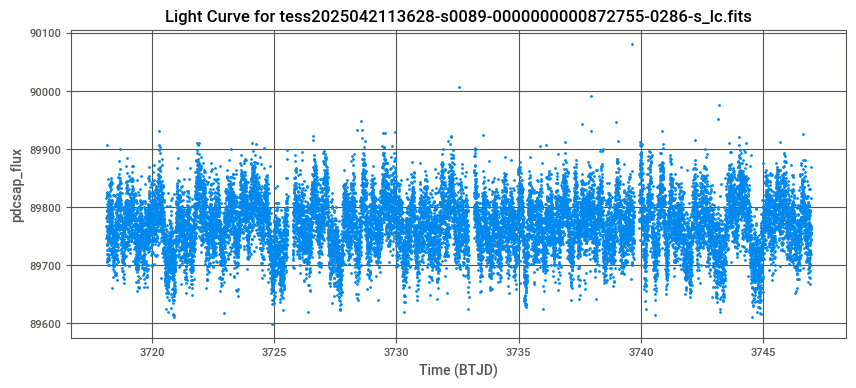

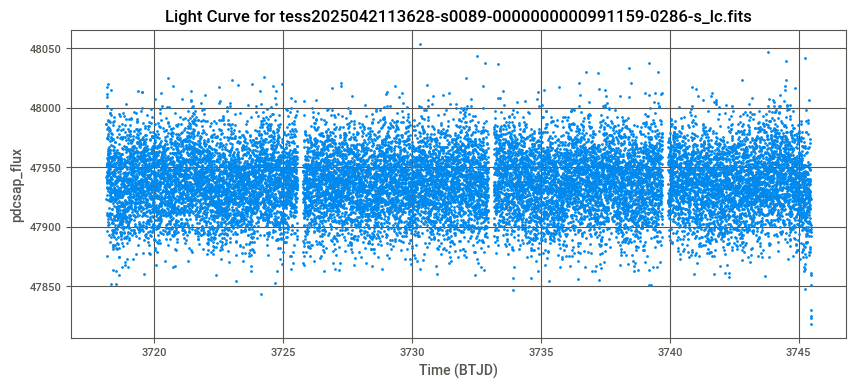

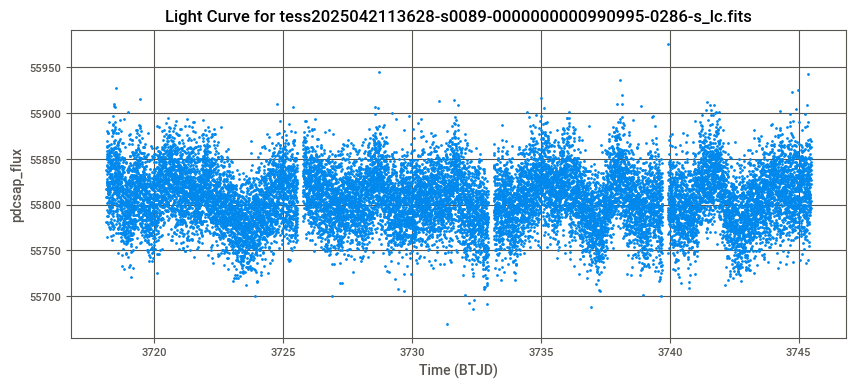

In [11]:
# Plot for how the data looks for different star types just to get a feel for it
for star in clean_df["source_file"].unique()[:3]:  # e.g., first 3 stars
    star_df = clean_df[clean_df["source_file"] == star]
    plt.figure(figsize=(10, 4))
    plt.plot(star_df["time"], star_df["pdcsap_flux"], '.', markersize=2)
    plt.title(f"Light Curve for {star}")
    plt.xlabel("Time (BTJD)")
    plt.ylabel("pdcsap_flux")
    plt.grid(True)
    plt.show()

2.7 Plots of distribution of data per column

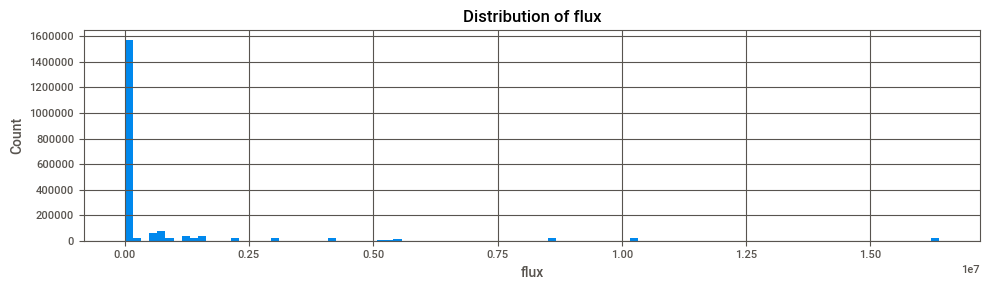

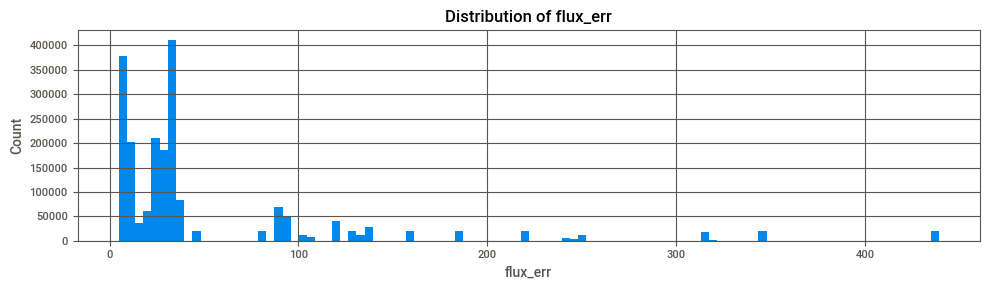

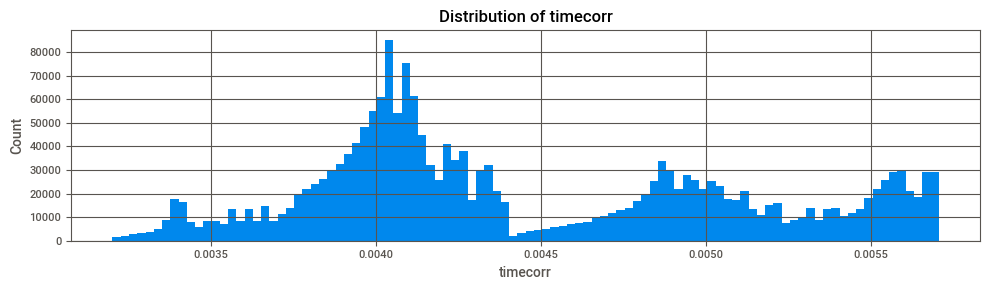

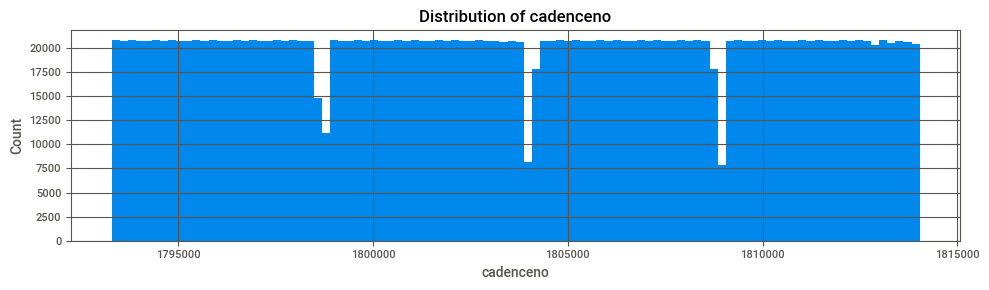

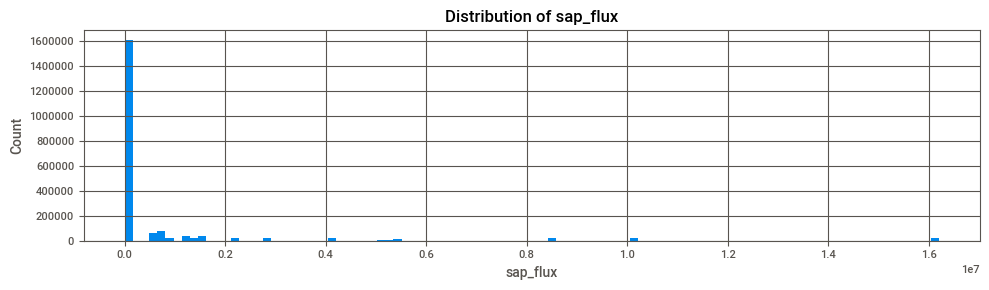

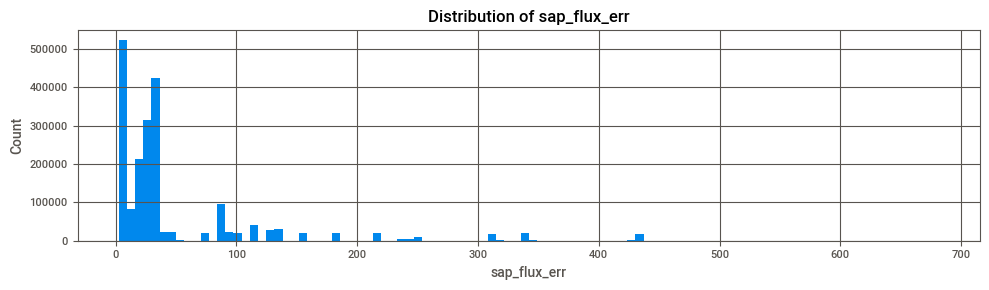

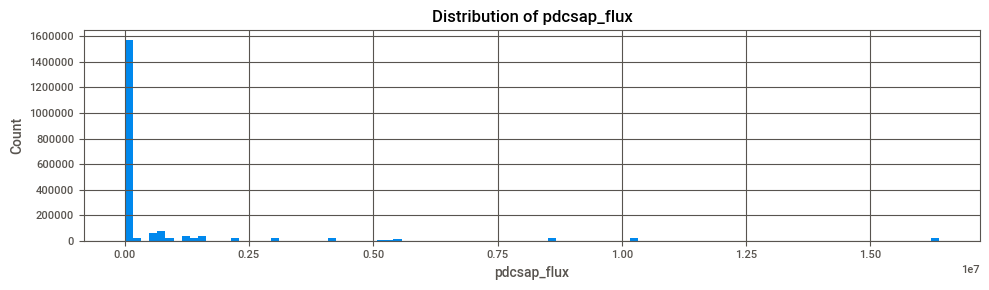

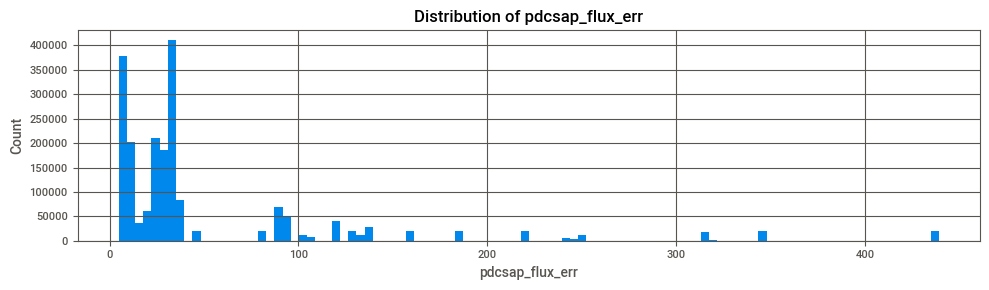

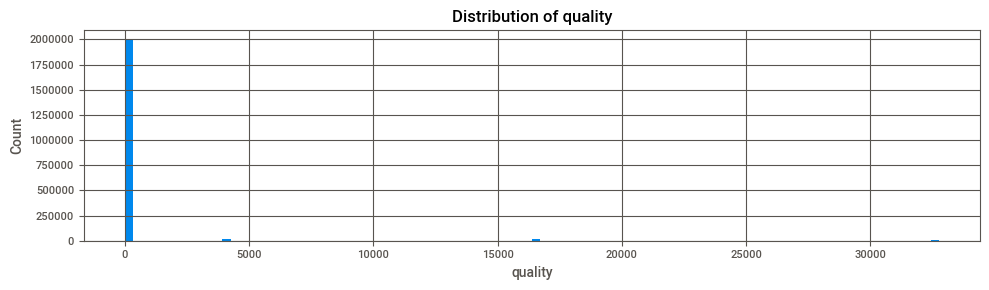

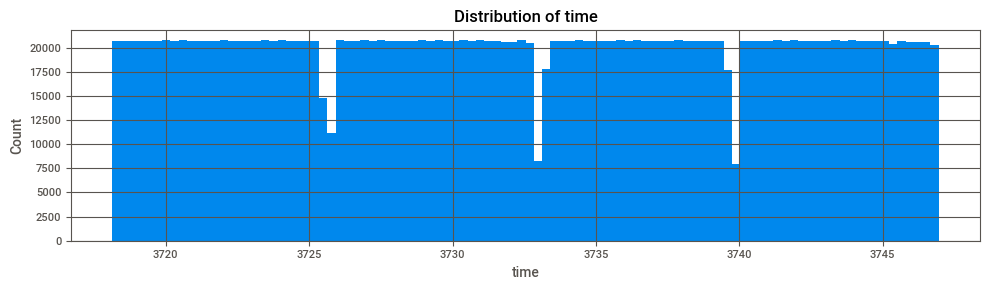

In [12]:
# look at distribution of data
numeric_cols = clean_df.select_dtypes(include='number').columns

for col in numeric_cols:
    plt.figure(figsize=(10, 3))
    clean_df[col].hist(bins=100)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

2.8 Plots of outliers in the column data

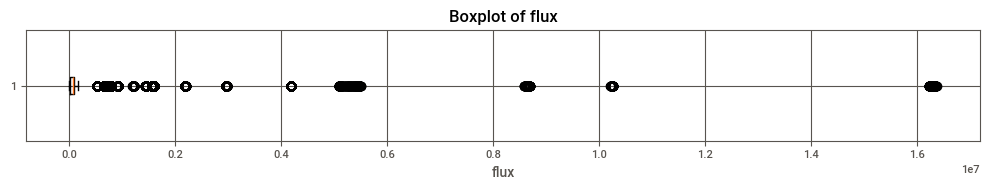

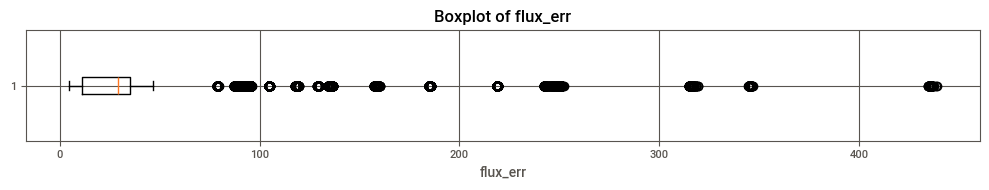

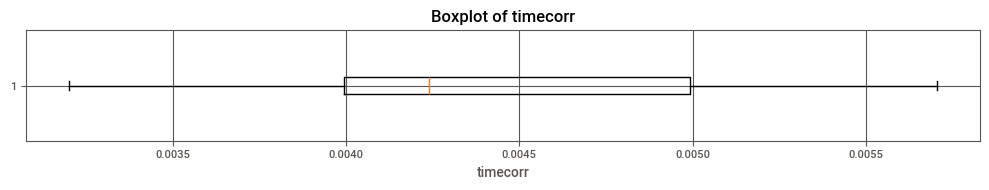

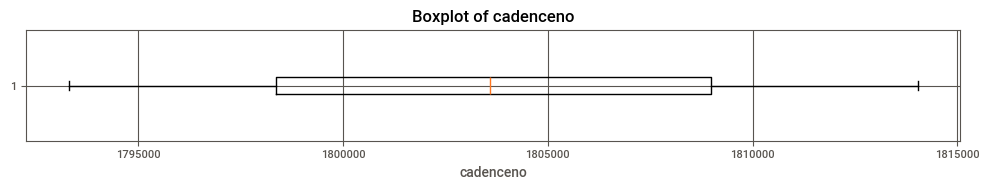

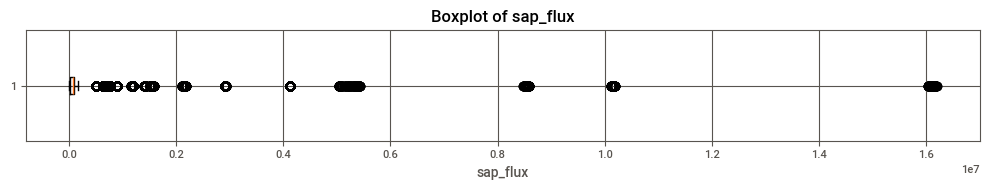

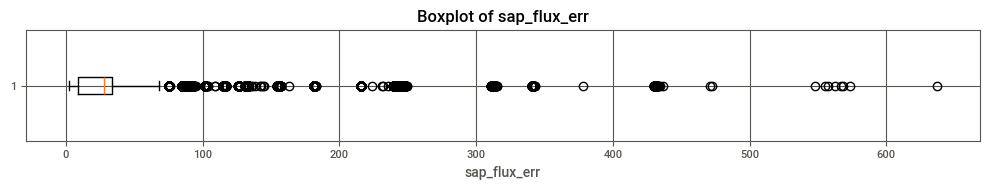

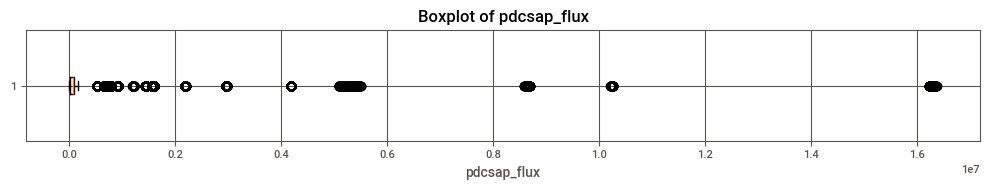

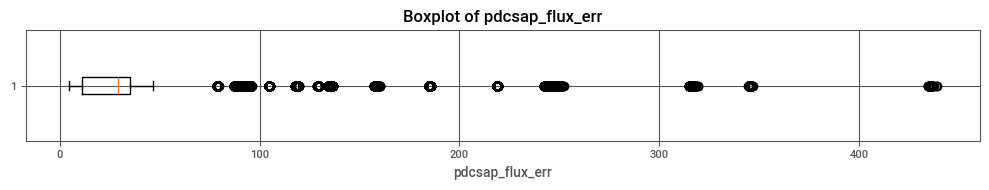

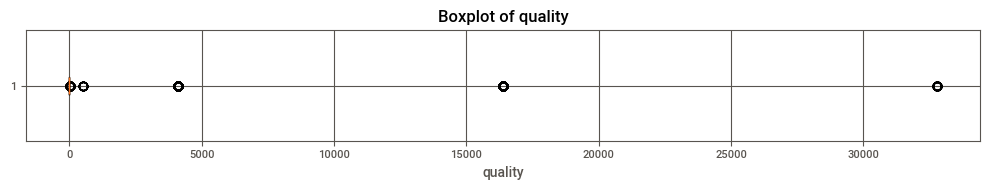

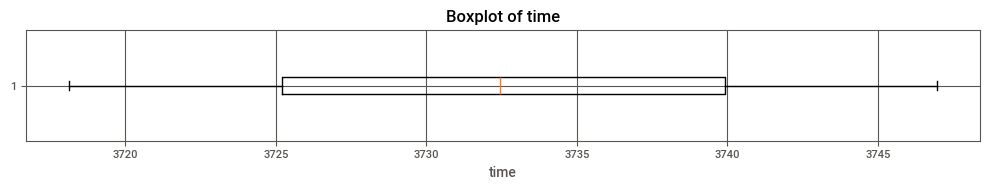

In [13]:
numeric_columns = clean_df.select_dtypes(include=['number']).columns
sample_df = clean_df.sample(frac=0.01, random_state=42)

for col in numeric_columns:
    plt.figure(figsize=(10, 2))
    plt.boxplot(sample_df[col].dropna(), vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

2.9 Further Data Insights from plots


Time - gaps could be down time in instruments where no data taken

Outliers ??? have outliers how to deal with them... again dont' want to mess with the actual real data too much as not familaiur enough with it . want to keep as much raw real data as possible.
could MinMaxScaler or winzorise.... what is best 

## Step 3 - Clean data

3.1 Drop empty columns from 'pdcsap_flux' and verify successful

In [15]:
# craete a new df off rclean_df so we cna have a clean df to work in and roll back to thsi point if we needed
clean_col_rem_df=clean_df.copy()

In [16]:
#drop empty coluimns in pdcsap_flux
clean_col_rem_df = clean_col_rem_df.dropna(subset=["pdcsap_flux"])

# # fill missing value error columns with median values
# # we will use median to avoid any potential skewness or outlier values
# clean2_df["pdcsap_flux_err"].fillna(clean2_df["pdcsap_flux_err"].median(), inplace=True)

In [17]:
print ("Rows     : " , clean_col_rem_df.shape[0])
print ("Columns  : " , clean_col_rem_df.shape[1])
print('------')
print ("\nFeatures : \n" , clean_col_rem_df.columns.tolist())
print('------')
print ("\nMissing values :  ", clean_col_rem_df.isnull().sum().values.sum())
print('------')
print ("\nMissing values per column:  \n", clean_col_rem_df.isnull().sum())
print('------')
print('\nnum of dups in df   =   {}'.format(clean_col_rem_df.duplicated().sum()))
print('------')
print ("\nUnique values :  \n", clean_col_rem_df.nunique())
print('------')
print('\n null values = ', clean_col_rem_df.isnull().values.any())
print('------')
clean_col_rem_df_missing = (df=='?').sum()
print('\"  ?   \" values present =  \n',clean_col_rem_df_missing)
print('------')
clean_col_rem_df_unknown = (clean_col_rem_df=='unknown').sum()
print('\"   unknown   \" values present =  \n',clean_col_rem_df_unknown)
print('------')
clean_col_rem_df_na = clean_col_rem_df.isin(['N/A', 'N\\A', 'NA', 'n/a', 'n\\A', 'na', 'N_A']).sum()
print('    NA     values present = \n', clean_col_rem_df_na)
print('------')
clean_col_rem_df_none = clean_col_rem_df.isin(['None', 'none']).sum()
print('    none    values present = \n', clean_col_rem_df_none)

Rows     :  1984671
Columns  :  11
------

Features : 
 ['flux', 'flux_err', 'timecorr', 'cadenceno', 'sap_flux', 'sap_flux_err', 'pdcsap_flux', 'pdcsap_flux_err', 'quality', 'time', 'source_file']
------

Missing values :   0
------

Missing values per column:  
 flux               0
flux_err           0
timecorr           0
cadenceno          0
sap_flux           0
sap_flux_err       0
pdcsap_flux        0
pdcsap_flux_err    0
quality            0
time               0
source_file        0
dtype: int64
------

num of dups in df   =   0
------

Unique values :  
 flux               1489542
flux_err           1549840
timecorr           1529090
cadenceno            20257
sap_flux           1612731
sap_flux_err       1577096
pdcsap_flux        1489542
pdcsap_flux_err    1549840
quality                  2
time               1984525
source_file            100
dtype: int64
------

 null values =  False
------
"  ?   " values present =  
 flux               0
flux_err           0
timecorr    

3.2 Further Data Insight

Removing the pdcsap_flux missing rows has removed the missing sap and flux and _err data also. Don't have any missing values on those rows now, which is good.

Normalisation is important as different stars have different brightness and is a range of values, bright star will skew dat fomr stars not as bright, so need tonormalise/stanmdarise this flux data so all balanced around a central norm i.e. baseline of 1.0

winsorisation - address outliers from influeicng analysis otucomes
we'll apply to numerical columns
we'll exclude the following form winsoristation
- 'quality' - flags about quality 0, 1. need to keep as is
- 'cadenceno' - more or less an indes
- 'time' - a set time value, a real number don't want to change
- 'timecorr' - as above
- 'source_file' - non-numerical, relates to star ID

3.3 Normalise the 'pdcsap_sap_flux' data and verify the chnages in a plot

In [ ]:
#Normalise Data

# normalises uses the median per star and we groupby star using the source_file column
# divide each flux value by that star's median flux value
# we use transform to make sure the result keeps the original df shape and alignment
# and we create a new column, 'pdcsap_flux_norm', to store the normalised data, sowe dont' lose the original
# will create new df to normalise and retain cleaned df in case need
clean_norm_df = clean_col_rem_df.copy()
clean_norm_df['pdcsap_flux_norm'] = clean_col_rem_df.groupby("source_file")['pdcsap_flux'].transform(lambda x: x / x.median())

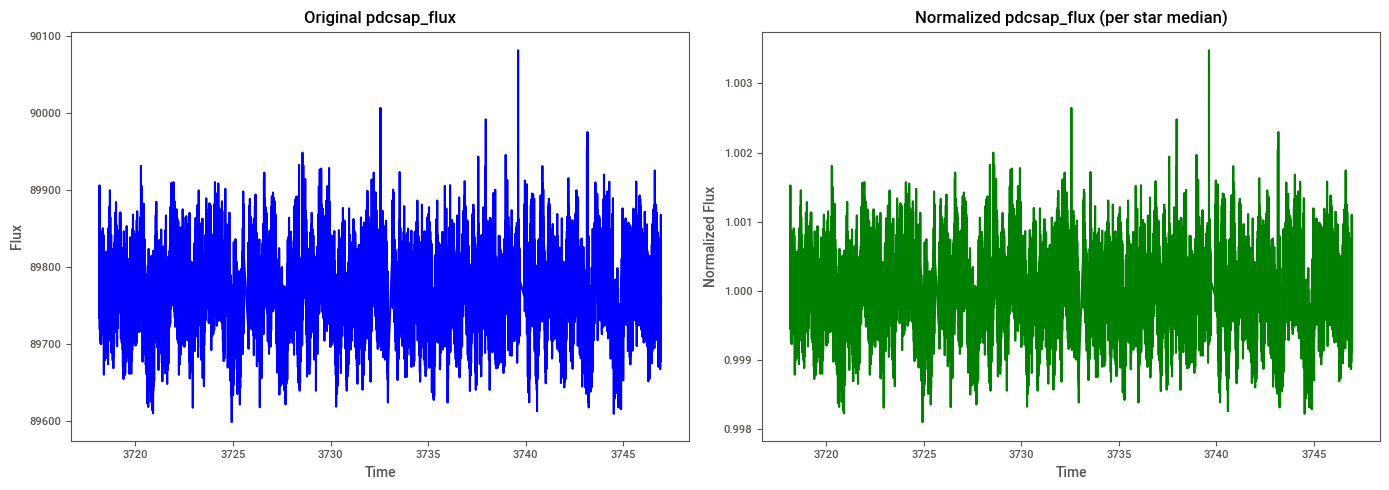

In [19]:
# Choose a single sample star which we'll pot before and after tocheck
# cnba use source file toget individual star data
example_star = clean_norm_df["source_file"].unique()[0]

# Filter data for that star
df_star = clean_norm_df[clean_norm_df["source_file"] == example_star]

# Plot original vs normalized pdcsap_flux
plt.figure(figsize=(14, 5))

# Original flux
plt.subplot(1, 2, 1)
plt.plot(df_star["time"], df_star["pdcsap_flux"], color='blue')
plt.title("Original pdcsap_flux")
plt.xlabel("Time")
plt.ylabel("Flux")

# Normalized flux
plt.subplot(1, 2, 2)
plt.plot(df_star["time"], df_star["pdcsap_flux_norm"], color='green')
plt.title("Normalized pdcsap_flux (per star median)")
plt.xlabel("Time")
plt.ylabel("Normalized Flux")

plt.tight_layout()
plt.show()

Normalisation plots above:

- before - large range of data on y axis, values spread are much larger
- After - data centred around a baseline of 1.0. Spread of data is much smalle around the baseline

3.4 Winsorise selected numerical columns and verify the chnages in a plot

In [20]:
# Winsorise Data

# 7. Winzorising the data for extreme values
# from scipy.stats.mstats import winsorize

# crteate new df to work in
clean_winsor_df=clean_norm_df.copy()

# identify cols to include
num_cols_1 = clean_norm_df.select_dtypes(include=['number']).columns
cols_to_excl=['quality', 'cadenceno', 'time', 'timecorr', 'source_file']
num_cols_2 = [col for col in num_cols_1 if col not in cols_to_excl]
print(num_cols_1)
print(num_cols_2)

# Define 1% limit on both tails)
lower = 0.01  # 1% percentile lower tail
upper = 0.99  # 99% percentile upper tail

# Apply winzoristiation 
for col in num_cols_2:
    col_data=clean_winsor_df[col].values
    winsorised=winsorize(col_data, limits=(lower, 1-upper))
    clean_winsor_df[col] = winsorised.filled()

Index(['flux', 'flux_err', 'timecorr', 'cadenceno', 'sap_flux', 'sap_flux_err',
       'pdcsap_flux', 'pdcsap_flux_err', 'quality', 'time',
       'pdcsap_flux_norm'],
      dtype='object')
['flux', 'flux_err', 'sap_flux', 'sap_flux_err', 'pdcsap_flux', 'pdcsap_flux_err', 'pdcsap_flux_norm']


In [21]:
clean_winsor_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
flux,1984671.0,5.944763e+05,1.792601e+06,2.808894e+01,5.615400e+03,6.363539e+04,9.444168e+04,1.025003e+07
flux_err,1984671.0,4.904461e+01,6.773579e+01,5.003173e+00,1.114961e+01,2.935878e+01,3.557361e+01,3.462266e+02
timecorr,1984671.0,4.448540e-03,6.400926e-04,3.200641e-03,3.988675e-03,4.219107e-03,4.973155e-03,5.704571e-03
cadenceno,1984671.0,1.803457e+06,5.911514e+03,1.793292e+06,1.798263e+06,1.803382e+06,1.808503e+06,1.814032e+06
sap_flux,1984671.0,5.852072e+05,1.770710e+06,4.785327e+01,5.126049e+03,5.997101e+04,8.947065e+04,1.018834e+07
sap_flux_err,1984671.0,4.686832e+01,6.746164e+01,2.796352e+00,8.886965e+00,2.758974e+01,3.350297e+01,3.422422e+02
pdcsap_flux,1984671.0,5.944763e+05,1.792601e+06,2.808894e+01,5.615400e+03,6.363539e+04,9.444168e+04,1.025003e+07
pdcsap_flux_err,1984671.0,4.904461e+01,6.773579e+01,5.003173e+00,1.114961e+01,2.935878e+01,3.557361e+01,3.462266e+02
quality,1984671.0,3.201498e-01,1.279900e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.120000e+02
time,1984671.0,3.732261e+03,8.210352e+00,3.718142e+03,3.725047e+03,3.732157e+03,3.739269e+03,3.746948e+03


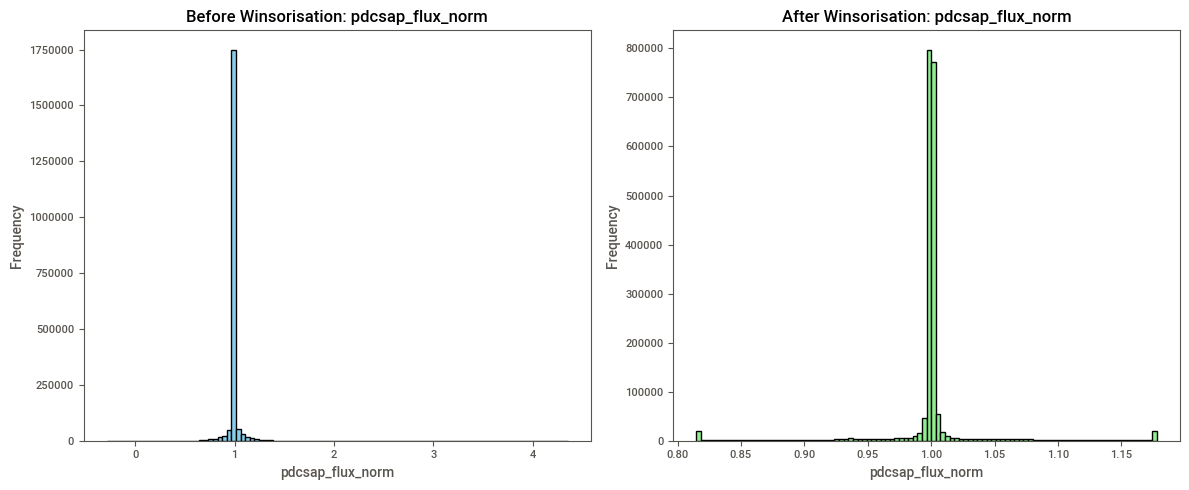

In [22]:
# quick check to see if data is as we expect post winsorising
# we'll plot pdc flus column to see difference as its our main column of interest
column_to_plot = 'pdcsap_flux_norm'  # or any other from num_cols_2

# Create histograms before and after winsorizstion
plt.figure(figsize=(12, 5))

# Before winsorization
plt.subplot(1, 2, 1)
plt.hist(clean_norm_df[column_to_plot], bins=100, color='skyblue', edgecolor='black')
plt.title(f'Before Winsorisation: {column_to_plot}')
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')

# After winsorization
plt.subplot(1, 2, 2)
plt.hist(clean_winsor_df[column_to_plot], bins=100, color='lightgreen', edgecolor='black')
plt.title(f'After Winsorisation: {column_to_plot}')
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Winsorisation plots above:

- before - goes up to 1.75 million form zero
- After - outliers outside of 1% percentile and 99% percentile have been removed. Data is tighter around 1.0

## Step 4 - Extract a feature from the Data to cluster

As it is time series data and we have multiple values per star we need to combines those values to a single, sumarised value per star so we can use them in clustering. we will extract those now in this section. 

we'll lok at number of dips in pdcsap_flux and time

4.1 Create new df of latest to work in

In [23]:
# create new df to work on from thsi point and retain latest one in case we need to return to a checkpoint in time
extract_feature_df=clean_winsor_df.copy()


4.2 Determine light curve dip data values from 'pdcsap_flux_norm' and Plot them to verify data is as expect

In [24]:
# play around wiht prominence value 
# >> 0.005 =  no dips, 
# >> 0.004 = 2, 1, and 6 dips
# >> 0.003 = 21, 42 and 25 dips
# Trial and error determien what a good value is and we're not including noise but real dip values and drops in intensity of light
# decided to go with 0.004 value to reduce the amount of false positives
def plot_light_curve_with_dips(df, star_id, flux_col='pdcsap_flux_norm', prominence=0.004):
    star_data = df[df['source_file'] == star_id]
    flux = star_data[flux_col].values
    time = star_data['time'].values

    # Find dips
    dips, _ = find_peaks(-flux, prominence=prominence)
    dip_count = len(dips)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, flux, label='Flux')
    plt.plot(time[dips], flux[dips], 'ro', label='Detected Dips')
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Normalized Flux')
    plt.title(f"Light Curve: {star_id}  |  Dips Found: {dip_count}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# [5] [SciPy - find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks)

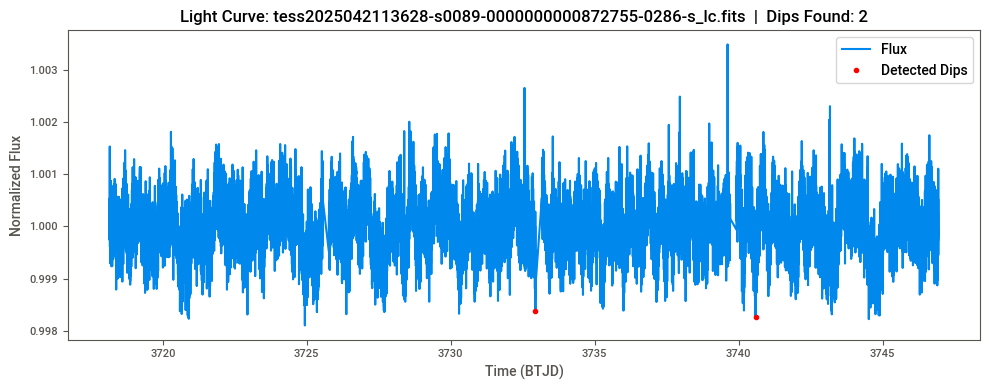

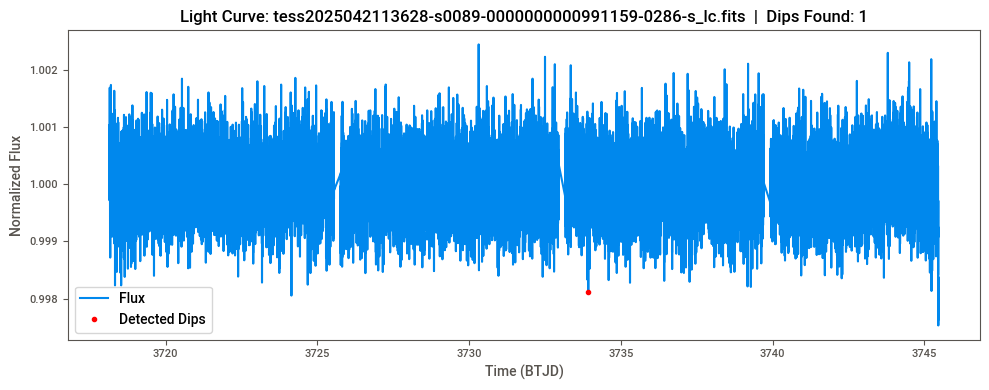

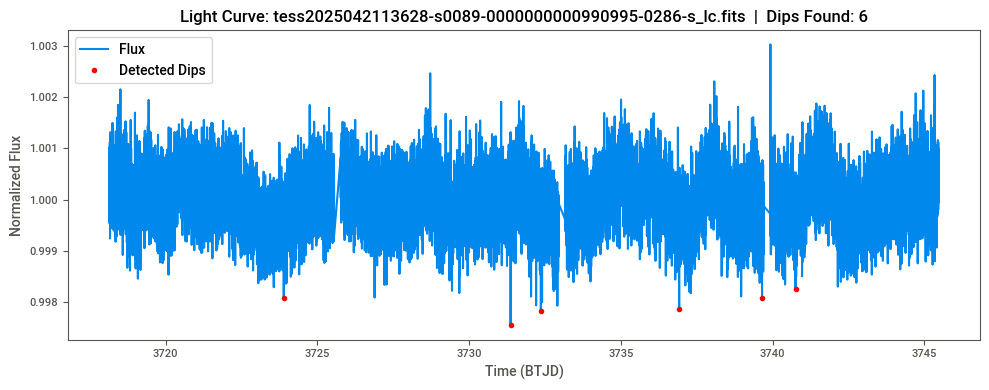

In [25]:
# Get 3 unique stars to plot
sample_stars = extract_feature_df['source_file'].unique()[:3]

# Plot them
for star in sample_stars:
    plot_light_curve_with_dips(extract_feature_df, star)

In [26]:
extract_feature_df.shape

(1984671, 12)

4.3 Calculate and Add flux dip data, 'num_flux_dips' to new column in dataframe

In [31]:
# Create a dictionary to store dip counts
num_flux_dips = {}

# Group by source_file (one light curve per star)
for source, group in extract_feature_df.groupby("source_file"):
    flux = group["pdcsap_flux_norm"].values
    # we invert the flux as per documentation toidentify the valleys/dips
    # set value at 0.004 as per earlier verification checks
    dips, _ = find_peaks(-flux, prominence=0.004) 
    num_flux_dips[source] = len(dips)


In [32]:
# Convert to DataFrame which we cna ten merge
num_flux_dips_df = pd.DataFrame(list(num_flux_dips.items()), columns=["source_file", "num_flux_dips"])

In [33]:
# Merge with your main dataframe on source_file)
extract_feature_df = extract_feature_df.merge(num_flux_dips_df, on="source_file", how="left")

In [49]:
print ("Rows     : " , extract_feature_df.shape[0])
print ("Columns  : " , extract_feature_df.shape[1])
print('------')
print ("\nFeatures : \n" , extract_feature_df.columns.tolist())
print('------')
print ("\nMissing values :  ", extract_feature_df.isnull().sum().values.sum())
print('------')
print ("\nMissing values per column:  \n", extract_feature_df.isnull().sum())
print('------')
print('\nnum of dups in df   =   {}'.format(extract_feature_df.duplicated().sum()))
print('------')
print ("\nUnique values :  \n", extract_feature_df.nunique())
print('------')
print('\n null values = ', extract_feature_df.isnull().values.any())
print('------')
extract_feature_df_missing = (df=='?').sum()
print('\"  ?   \" values present =  \n',extract_feature_df_missing)
print('------')
extract_feature_df_unknown = (extract_feature_df=='unknown').sum()
print('\"   unknown   \" values present =  \n',extract_feature_df_unknown)
print('------')
extract_feature_df_na = extract_feature_df.isin(['N/A', 'N\\A', 'NA', 'n/a', 'n\\A', 'na', 'N_A']).sum()
print('    NA     values present = \n', extract_feature_df_na)
print('------')
extract_feature_df_none = extract_feature_df.isin(['None', 'none']).sum()
print('    none    values present = \n', extract_feature_df_none)

Rows     :  1984671
Columns  :  13
------

Features : 
 ['flux', 'flux_err', 'timecorr', 'cadenceno', 'sap_flux', 'sap_flux_err', 'pdcsap_flux', 'pdcsap_flux_err', 'quality', 'time', 'source_file', 'pdcsap_flux_norm', 'num_flux_dips']
------

Missing values :   0
------

Missing values per column:  
 flux                0
flux_err            0
timecorr            0
cadenceno           0
sap_flux            0
sap_flux_err        0
pdcsap_flux         0
pdcsap_flux_err     0
quality             0
time                0
source_file         0
pdcsap_flux_norm    0
num_flux_dips       0
dtype: int64
------

num of dups in df   =   0
------

Unique values :  
 flux                1451680
flux_err            1514753
timecorr            1529090
cadenceno             20257
sap_flux            1575093
sap_flux_err        1541825
pdcsap_flux         1451680
pdcsap_flux_err     1514753
quality                   2
time                1984525
source_file             100
pdcsap_flux_norm     399773
nu

4.4 Calculate the variability of the flux per star, we'll use the standard deviation to represent this, 'flux_std'

In [52]:
flux_std_df = extract_feature_df.groupby("source_file").agg(flux_std=('pdcsap_flux_norm', 'std')).reset_index()

4.5 Calculate average dip duration per star, 'dip_duration'

In [53]:
# we cna calculate the width of the invert peaks, which are the dips
dip_durations = []

for source, group in extract_feature_df.groupby("source_file"):
    flux = group["pdcsap_flux_norm"].values
    time = group["time"].values
    dips, _ = find_peaks(-flux, prominence=0.004)
    
    # Calculate widths in time units
    results_half = peak_widths(-flux, dips, rel_height=0.5)
    widths = results_half[0]  # widths in data points

    # convert to time units using time difference
    if len(widths) > 0:
        avg_duration = np.mean(widths * np.median(np.diff(time)))
    else:
        avg_duration = 0
    
    dip_durations.append({"source_file": source, "avg_dip_duration": avg_duration})

dip_duration_df = pd.DataFrame(dip_durations)

4.6 Merge all calculated per star data into a dataframe and verify

In [62]:
# take source file and num_flux_dips from df and put them into a new df to use in clustering
x_features_df = extract_feature_df[['source_file', 'num_flux_dips']].drop_duplicates()

# add flus_std column data
x_features_df = x_features_df.merge(flux_std_df, on="source_file", how="left")

# add dip duration data 
x_features_df = x_features_df.merge(dip_duration_df, on="source_file", how="left")

In [65]:
x_features_df.head()

,source_file,num_flux_dips,flux_std,avg_dip_duration
0,tess2025042113628-s0089-0000000000872755-0286-...,2,0.000530,0.090759
1,tess2025042113628-s0089-0000000000991159-0286-...,1,0.000536,0.011295
2,tess2025042113628-s0089-0000000000990995-0286-...,6,0.000559,0.013028
3,tess2025042113628-s0089-0000000001228450-0286-...,0,0.000324,0.000000
4,tess2025042113628-s0089-0000000001137183-0286-...,2429,0.002072,0.003628


In [64]:
print ("Rows     : " , x_features_df.shape[0])
print ("Columns  : " , x_features_df.shape[1])
print('------')
print ("\nFeatures : \n" , x_features_df.columns.tolist())
print('------')
print ("\nMissing values :  ", x_features_df.isnull().sum().values.sum())
print('------')
print ("\nMissing values per column:  \n", x_features_df.isnull().sum())
print('------')
print('\nnum of dups in df   =   {}'.format(x_features_df.duplicated().sum()))
print('------')
print ("\nUnique values :  \n", x_features_df.nunique())
print('------')
print('\n null values = ', x_features_df.isnull().values.any())
print('------')
x_features_df_missing = (df=='?').sum()
print('\"  ?   \" values present =  \n',x_features_df_missing)
print('------')
x_features_df_unknown = (x_features_df=='unknown').sum()
print('\"   unknown   \" values present =  \n',x_features_df_unknown)
print('------')
x_features_df_na = x_features_df.isin(['N/A', 'N\\A', 'NA', 'n/a', 'n\\A', 'na', 'N_A']).sum()
print('    NA     values present = \n', x_features_df_na)
print('------')
x_features_df_none = x_features_df.isin(['None', 'none']).sum()
print('    none    values present = \n', x_features_df_none)

Rows     :  100
Columns  :  4
------

Features : 
 ['source_file', 'num_flux_dips', 'flux_std', 'avg_dip_duration']
------

Missing values :   0
------

Missing values per column:  
 source_file         0
num_flux_dips       0
flux_std            0
avg_dip_duration    0
dtype: int64
------

num of dups in df   =   0
------

Unique values :  
 source_file         100
num_flux_dips        61
flux_std            100
avg_dip_duration     86
dtype: int64
------

 null values =  False
------
"  ?   " values present =  
 flux               0
flux_err           0
timecorr           0
cadenceno          0
centroid_col       0
centroid_row       0
sap_flux           0
sap_flux_err       0
sap_bkg            0
sap_bkg_err        0
pdcsap_flux        0
pdcsap_flux_err    0
quality            0
psf_centr1         0
psf_centr1_err     0
psf_centr2         0
psf_centr2_err     0
mom_centr1         0
mom_centr1_err     0
mom_centr2         0
mom_centr2_err     0
pos_corr1          0
pos_corr2         

4.7 Data Insights

- we have 100 unique source file values which means data 100 stars
- we have 61 flux dip values, which hopefully is a reasonable spread
- we have 86 dip duration values
- we have 100 flux_std values
- There is a range in the date so we will need to normalise the data
- there are 0.0 values present, they are zero values and not missing values, so we will leave them as trying to keep as much original data as possible

4.8 Normalise the dataframe and verify it is as we expect

In [ ]:
features = ['num_flux_dips', 'flux_std', 'avg_dip_duration']
scaler = MinMaxScaler()
x_features_norm_df = scaler.fit_transform(x_features_df[features])

In [ ]:
# convetr back to datafram as scaler.fit_transform gives us a numpy array
x_features_norm_df = pd.DataFrame(x_features_norm_df, columns=features, index=x_features_df.index)

# add back in the source _file column as lost it in the normalization
x_features_norm_df = pd.DataFrame(x_features_norm_df, columns=features, index=x_features_df.index)
x_features_norm_df["source_file"] = x_features_df["source_file"].values

# quick look at its shape
x_features_norm_df.shape

(100, 4)

In [76]:
print ("Rows     : " , x_features_norm_df.shape[0])
print ("Columns  : " , x_features_norm_df.shape[1])
print('------')
print ("\nFeatures : \n" , x_features_norm_df.columns.tolist())
print('------')
print ("\nMissing values :  ", x_features_norm_df.isnull().sum().values.sum())
print('------')
print ("\nMissing values per column:  \n", x_features_norm_df.isnull().sum())
print('------')
print('\nnum of dups in df   =   {}'.format(x_features_norm_df.duplicated().sum()))
print('------')
print ("\nUnique values :  \n", x_features_norm_df.nunique())
print('------')
print('\n null values = ', x_features_norm_df.isnull().values.any())
print('------')
x_features_norm_df_missing = (df=='?').sum()
print('\"  ?   \" values present =  \n',x_features_df_missing)
print('------')
x_features_norm_df_unknown = (x_features_norm_df=='unknown').sum()
print('\"   unknown   \" values present =  \n',x_features_norm_df_unknown)
print('------')
x_features_norm_df_na = x_features_norm_df.isin(['N/A', 'N\\A', 'NA', 'n/a', 'n\\A', 'na', 'N_A']).sum()
print('    NA     values present = \n', x_features_norm_df_na)
print('------')
x_features_norm_df_none = x_features_norm_df.isin(['None', 'none']).sum()
print('    none    values present = \n', x_features_norm_df_none)

Rows     :  100
Columns  :  4
------

Features : 
 ['num_flux_dips', 'flux_std', 'avg_dip_duration', 'source_file']
------

Missing values :   0
------

Missing values per column:  
 num_flux_dips       0
flux_std            0
avg_dip_duration    0
source_file         0
dtype: int64
------

num of dups in df   =   0
------

Unique values :  
 num_flux_dips        61
flux_std            100
avg_dip_duration     86
source_file         100
dtype: int64
------

 null values =  False
------
"  ?   " values present =  
 flux               0
flux_err           0
timecorr           0
cadenceno          0
centroid_col       0
centroid_row       0
sap_flux           0
sap_flux_err       0
sap_bkg            0
sap_bkg_err        0
pdcsap_flux        0
pdcsap_flux_err    0
quality            0
psf_centr1         0
psf_centr1_err     0
psf_centr2         0
psf_centr2_err     0
mom_centr1         0
mom_centr1_err     0
mom_centr2         0
mom_centr2_err     0
pos_corr1          0
pos_corr2         

## Step 5 - Clustering

5.1 - Create a new dataframe with one row per star on our feature

In [183]:
# create a new dataframe to work in
x_df = x_features_norm_df.copy()

In [184]:
# drop sopurce_file as kmeans fit expects al numerical data
x_df = x_df.drop(columns=["source_file"])

In [185]:
x_df.head()

,num_flux_dips,flux_std,avg_dip_duration
0,0.000288,0.002428,0.022857
1,0.000144,0.002475,0.002845
2,0.000865,0.002629,0.003281
3,0.000000,0.001005,0.000000
4,0.350353,0.013124,0.000914


In [ ]:
# scaler = MinMaxScaler()

# # Normalize 'num_flux_dips'
# scaler.fit(x_df[['num_flux_dips']])
# x_df['num_flux_dips'] = scaler.transform(x_df[['num_flux_dips']])

# # Normalize 'avg_dip_duration'
# scaler.fit(x_df[['avg_dip_duration']])
# x_df['avg_dip_duration'] = scaler.transform(x_df[['avg_dip_duration']])

# # Normalize 'flux_std'
# scaler.fit(x_df[['flux_std']])
# x_df['flux_std'] = scaler.transform(x_df[['flux_std']])

In [40]:
# creat6e new dataframe that will contain one row per star
x_df = x_df[["source_file", "num_flux_dips"]].drop_duplicates(subset=["source_file"])


#  we just need the numerical column(s)
x_features = x_df[["num_flux_dips"]]

In [186]:
x_df.shape

(100, 3)

5.2 Plot elbow curve to determine appropriate cluster count

c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmea

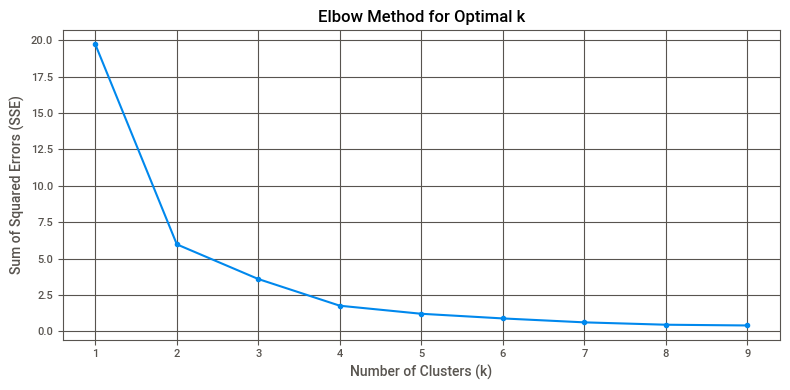

In [187]:
# Try different cluster counts
sse = []
k_range = range(1, 10)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(x_df)
    sse.append(km.inertia_)  # Sum of squared distances

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.tight_layout()
plt.show()

5.3 Create KMeans cluster and analyze data

In [201]:
# # initialise the kmeans model with 2 clusters and we're just using num_flux_dips column to cerry out clustering
# # we'll add thre resulting cluster label of 1 or 0 as a new column in x_features called cluster
# kmeans = KMeans(n_clusters=3, random_state=42)
# x_df["cluster"] = kmeans.fit_predict(x_df[["num_flux_dips", "avg_dip_duration", "flux_std"]])

#x_df(["cluster"].value_counts())

In [202]:
#Now create a K-means model containing 2 clustsers
# we dicded ont his after tryign all values and also after silhouette plot calculation
km = KMeans(n_clusters=2)
y_predicted = km.fit_predict(x_df[['num_flux_dips',"avg_dip_duration", "flux_std"]])
#display the predicted clusters
y_predicted

c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [203]:
#Add the clusters to the original DF, to have all the data together
#x_df['cluster']=y_predicted
x_df.head()

,num_flux_dips,flux_std,avg_dip_duration,cluster
0,0.000288,0.002428,0.022857,0
1,0.000144,0.002475,0.002845,0
2,0.000865,0.002629,0.003281,0
3,0.000000,0.001005,0.000000,0
4,0.350353,0.013124,0.000914,0


In [204]:
#We can examine different aspects of the model
#Here we list the Centroids for the 3 clusters
km.cluster_centers_

array([[7.72944401e-02, 6.03345047e-02, 1.50447120e-02],
       [9.23169383e-01, 6.89811090e-04, 6.13679104e-01]])

5.4 Plot Kmeans cluster data

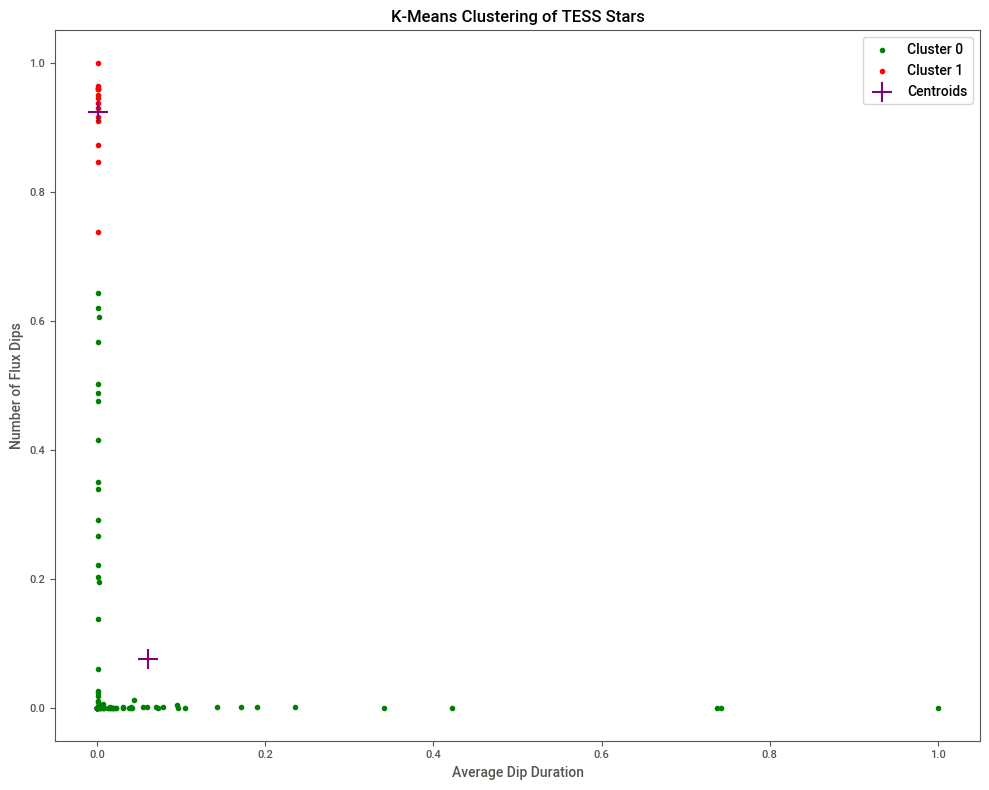

In [205]:
# Separate out each cluster for custom formatting
df0 = x_df[x_df.cluster == 0]
df1 = x_df[x_df.cluster == 1]
# df2 = x_df[x_df.cluster == 2]

# Plot each cluster with a different color
plt.scatter(df0['avg_dip_duration'], df0['num_flux_dips'], color='green', label='Cluster 0')
plt.scatter(df1['avg_dip_duration'], df1['num_flux_dips'], color='red', label='Cluster 1')
# plt.scatter(df2['avg_dip_duration'], df2['num_flux_dips'], color='blue', label='Cluster 2')

# Plot centroids
plt.scatter(km.cluster_centers_[:,1], km.cluster_centers_[:,0], color='purple', marker='+', s=200, label='Centroids')

# Label axes
plt.xlabel('Average Dip Duration')
plt.ylabel('Number of Flux Dips')
plt.title('K-Means Clustering of TESS Stars')
plt.legend()
plt.tight_layout()
plt.show()

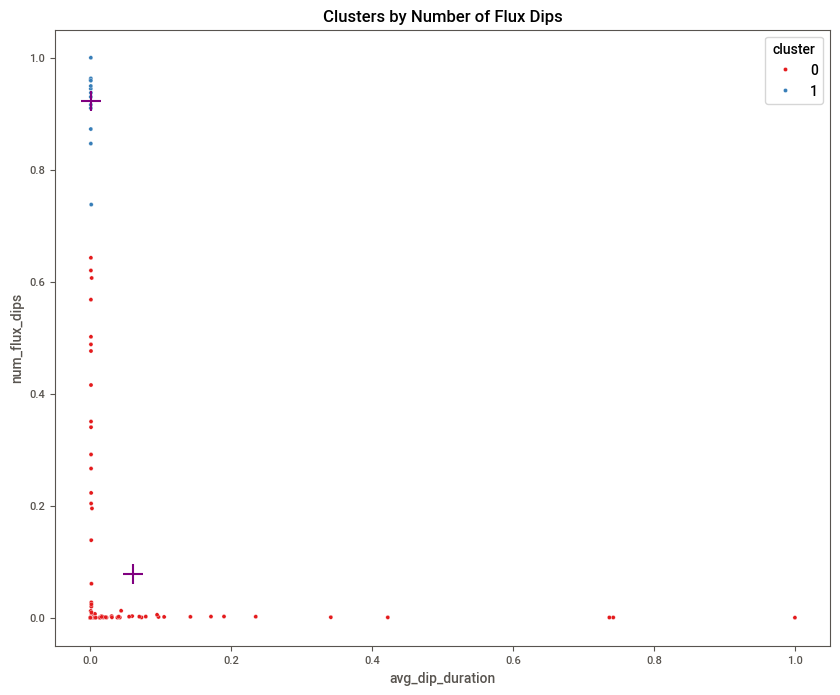

In [206]:
sns.scatterplot(data=x_df, x="avg_dip_duration", y="num_flux_dips", hue="cluster", palette="Set1")

# Plot centroids
plt.scatter(km.cluster_centers_[:,1], km.cluster_centers_[:,0], color='purple', marker='+', s=200, label='Centroids')

plt.title("Clusters by Number of Flux Dips")
plt.show()



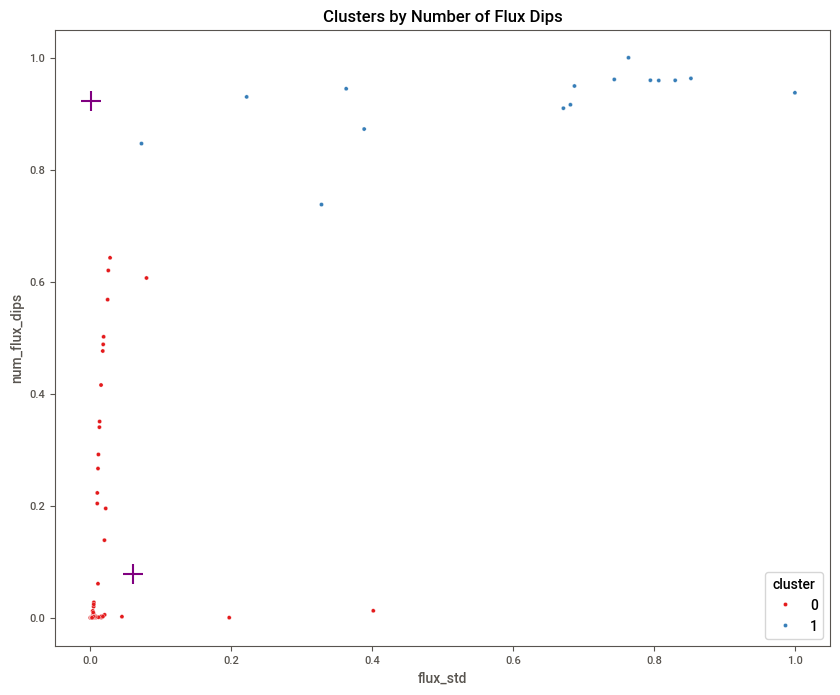

In [207]:
sns.scatterplot(data=x_df, x="flux_std", y="num_flux_dips", hue="cluster", palette="Set1")
# Plot centroids
plt.scatter(km.cluster_centers_[:,1], km.cluster_centers_[:,0], color='purple', marker='+', s=200, label='Centroids')

plt.title("Clusters by Number of Flux Dips")
plt.show()

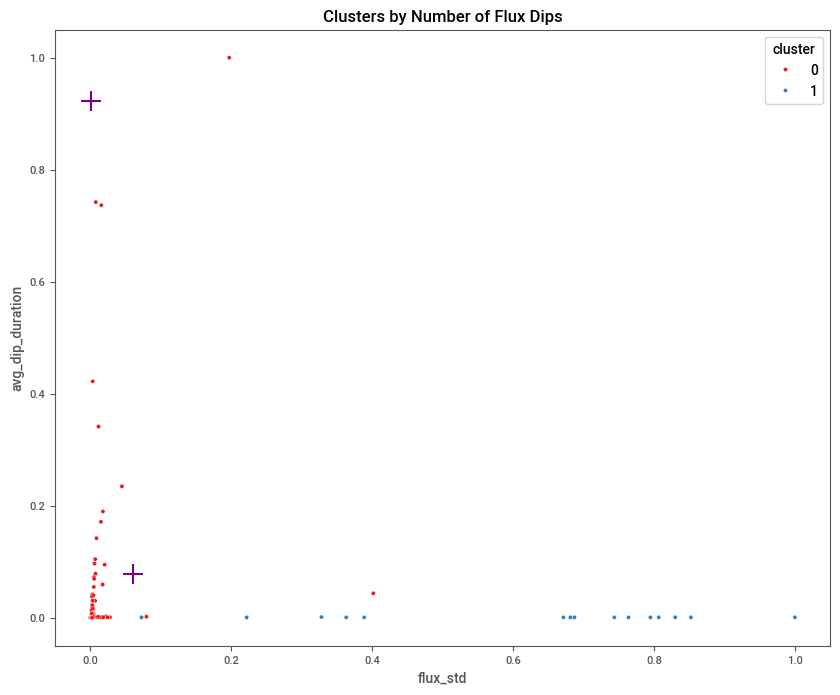

In [208]:
sns.scatterplot(data=x_df, x="flux_std", y="avg_dip_duration", hue="cluster", palette="Set1")

# Plot centroids
plt.scatter(km.cluster_centers_[:,1], km.cluster_centers_[:,0], color='purple', marker='+', s=200, label='Centroids')

plt.title("Clusters by Number of Flux Dips")
plt.show()

5.5 Plot Kmeans cluster data in 3D

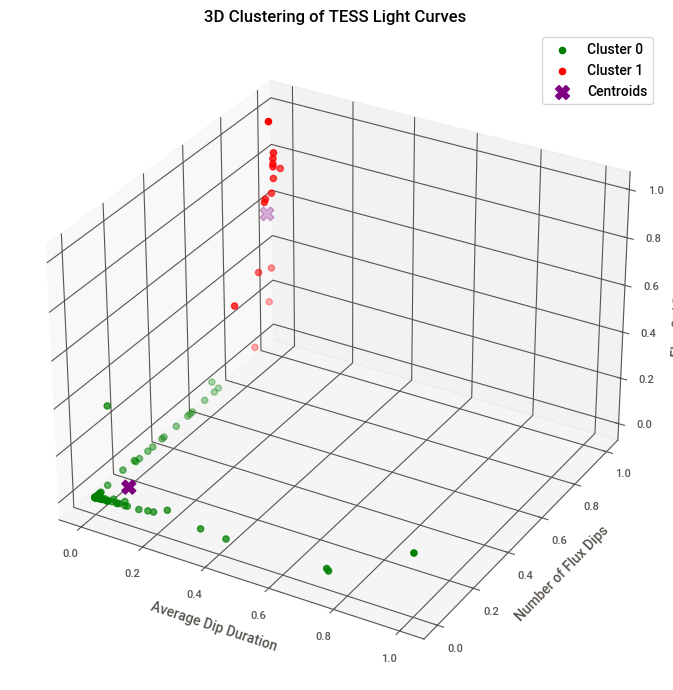

In [ ]:
# a 3D plot with k value of 2 clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
ax.scatter(df0['avg_dip_duration'], df0['num_flux_dips'], df0['flux_std'], color='green', label='Cluster 0')
ax.scatter(df1['avg_dip_duration'], df1['num_flux_dips'], df1['flux_std'], color='red', label='Cluster 1')
#ax.scatter(df2['avg_dip_duration'], df2['num_flux_dips'], df2['flux_std'], color='blue', label='Cluster 2')

# Plot centroids
ax.scatter(km.cluster_centers_[:, 1], km.cluster_centers_[:, 0], km.cluster_centers_[:, 2], 
           color='purple', marker='X', s=100, label='Centroids')

# Axis labels
ax.set_xlabel('Average Dip Duration')
ax.set_ylabel('Number of Flux Dips')
ax.set_zlabel('Flux Std Deviation')
ax.set_title('3D Clustering of TESS Light Curves')
ax.legend()
plt.tight_layout()
plt.show()

5.6 Initial Data Insights

- decided to go with k=3 as it seemed like mid way point bertween 2 and 4 where biggest change occured
 
```sh
k=2
cluster
0    78
1    22
Name: count, dtype: int64
-----------------------
k=3
cluster
0    73
1    15
2    12
Name: count, dtype: int64
--------------------
k= 4 
cluster
0    70
3    14
2     8
1     8
Name: count, dtype: int64
```

- 2D
    - clusters are linear in nature, separation is present but seem alligned
    - There are zero values present which perhaps Zero values could represent low activity in stars. They are not missing values, but actual 0.0 values
    - Data does look strange and haven't been able to figure out why ....

- 3D plot 
    - x axis = avg fip duration
    - y axis = num of flux dips
    - z axis = flux variability
    - CVlusters are well separtated in 3D plot, less so in 2D plot
    - centroids are where we would expect - indicating the average value for the set of clusters

5.7 Plot Kmeans++ data

c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


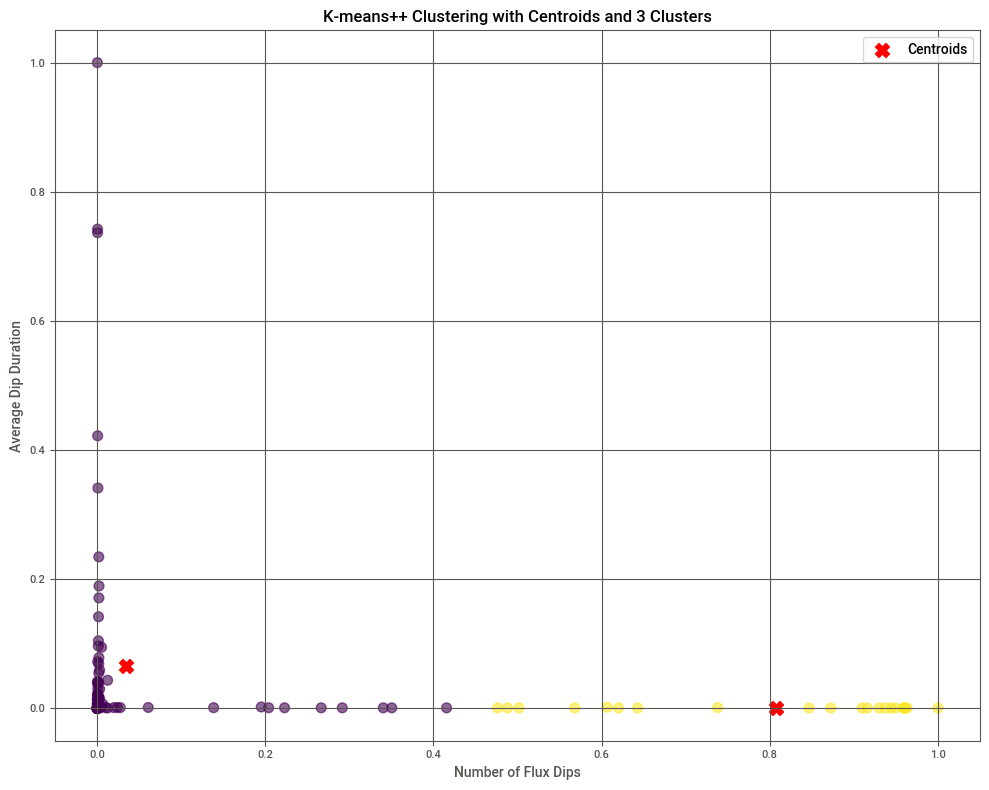

In [211]:
# Perform KMeans++ clustering
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans.fit(x_df[["num_flux_dips", "avg_dip_duration"]])

# Get centroids
centroids = kmeans.cluster_centers_

# Add cluster labels to DataFrame
x_df["kmeans_pp_cluster"] = kmeans.labels_

# Plot
plt.figure(figsize=(10, 8))
plt.title("K-means++ Clustering with Centroids and 3 Clusters")
plt.xlabel("Number of Flux Dips")
plt.ylabel("Average Dip Duration")

plt.scatter(
    x_df["num_flux_dips"], 
    x_df["avg_dip_duration"], 
    c=kmeans.labels_, 
    cmap='viridis', 
    s=50, alpha=0.6
)
plt.scatter(
    centroids[:, 0], 
    centroids[:, 1], 
    c='red', 
    s=100, 
    marker='X', 
    label='Centroids'
)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

5.7 Calculate and Display the Silhouette values

the silhouette value can help us evaluate the quality of clustering. It may determine how well data points fit within their assigned clusters and whether the number of clusters is optimal

c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmea

For n_clusters = 2, the average silhouette_score is: 0.7577
For n_clusters = 3, the average silhouette_score is: 0.7044
For n_clusters = 4, the average silhouette_score is: 0.7463
For n_clusters = 5, the average silhouette_score is: 0.7143
For n_clusters = 6, the average silhouette_score is: 0.7146
For n_clusters = 7, the average silhouette_score is: 0.7201
For n_clusters = 8, the average silhouette_score is: 0.7366


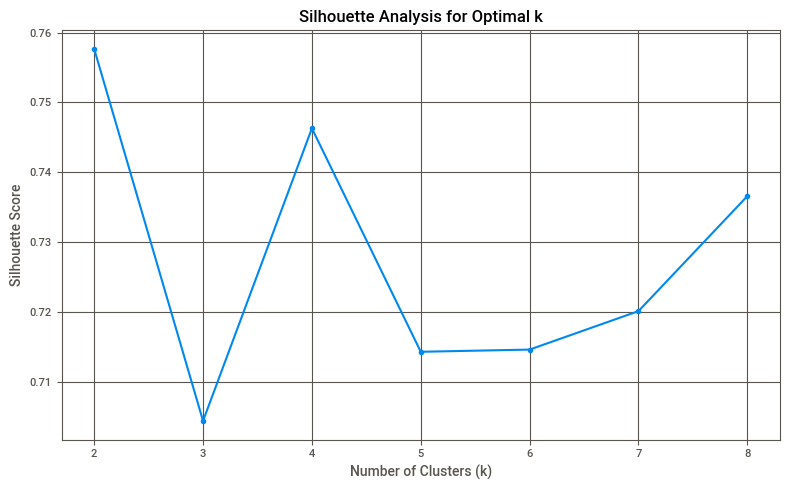

In [216]:

features = ['num_flux_dips', 'avg_dip_duration', 'flux_std']
df_for_clustering = x_df[features]

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []

for num_clusters in range_n_clusters:
    # Initialize KMeans++
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(df_for_clustering)
    
    # Calculate average silhouette score
    score = silhouette_score(df_for_clustering, cluster_labels)
    silhouette_avg.append(score)
    print(f"For n_clusters = {num_clusters}, the average silhouette_score is: {score:.4f}")

# Plot the silhouette scores for each cluster count
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.grid(True)
plt.tight_layout()
plt.show()

5.9 Alternative silhouette data plot

c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 2, average silhouette_score = 0.7577


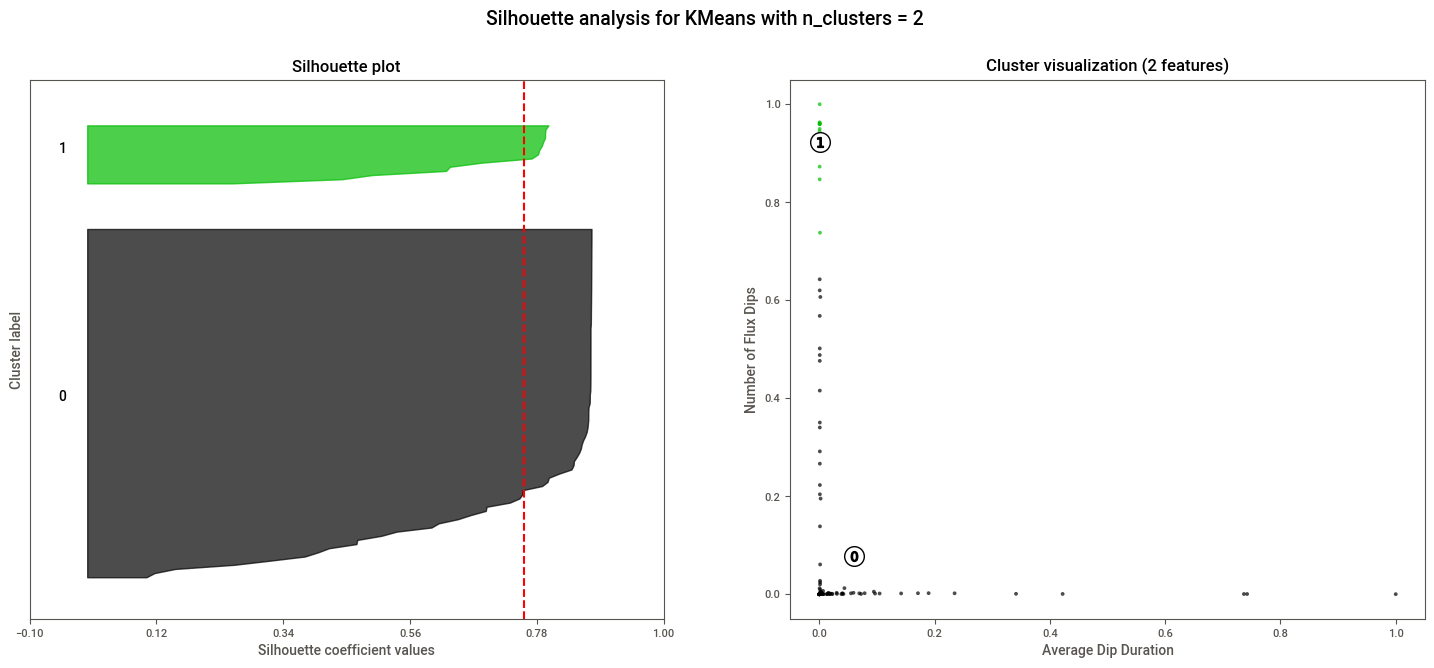

c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 3, average silhouette_score = 0.7044


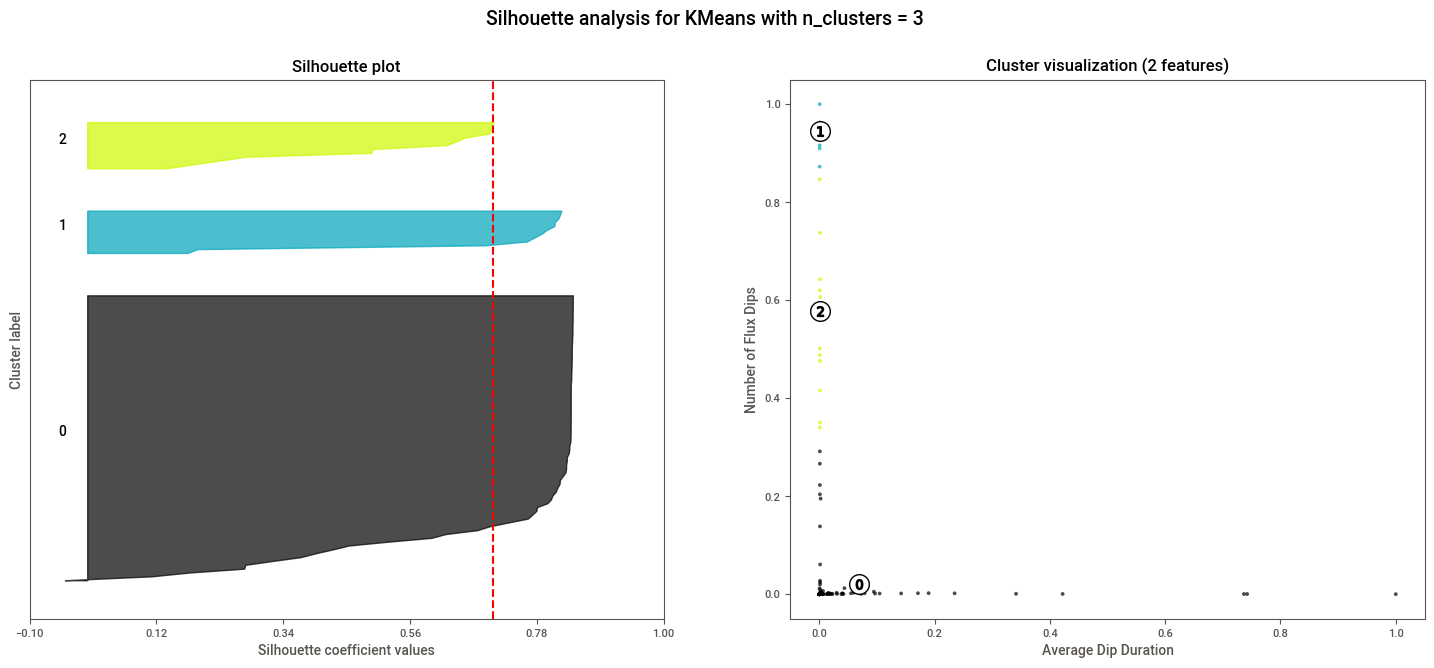

c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 4, average silhouette_score = 0.7463


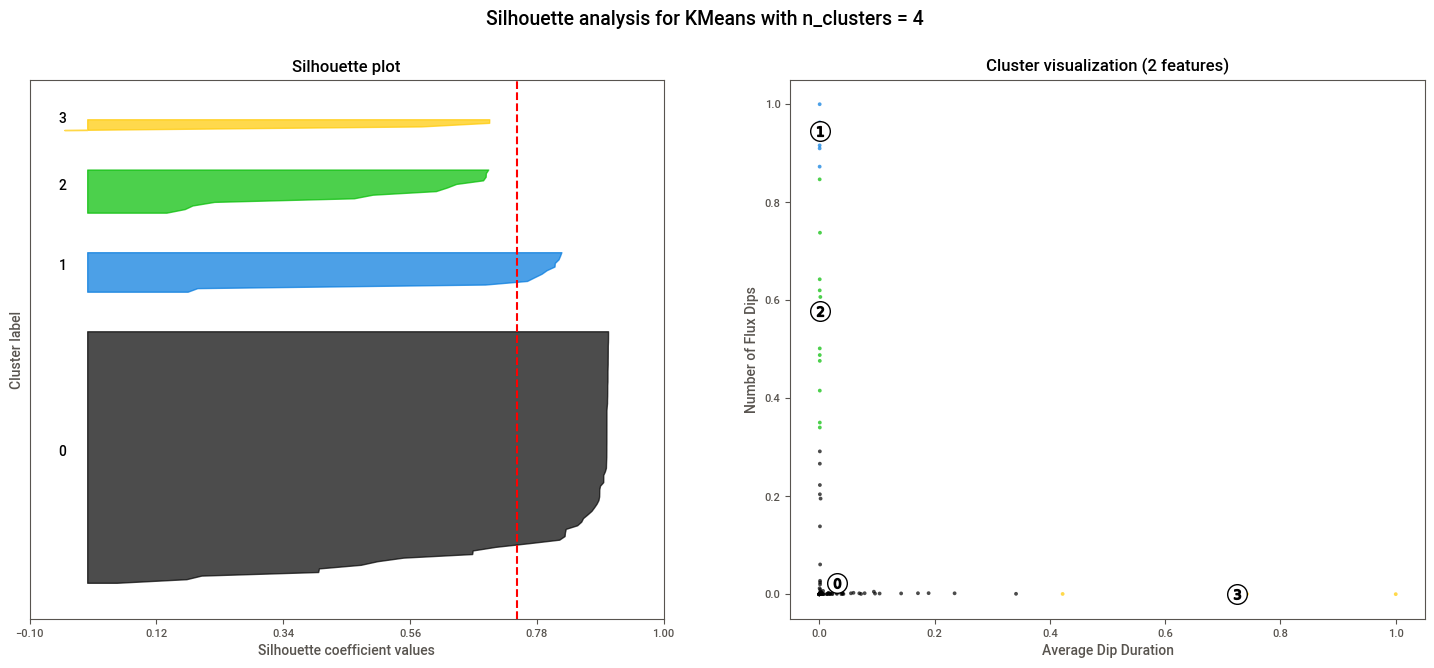

c:\Users\eamon\anaconda3\envs\assignment-a\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 5, average silhouette_score = 0.7143


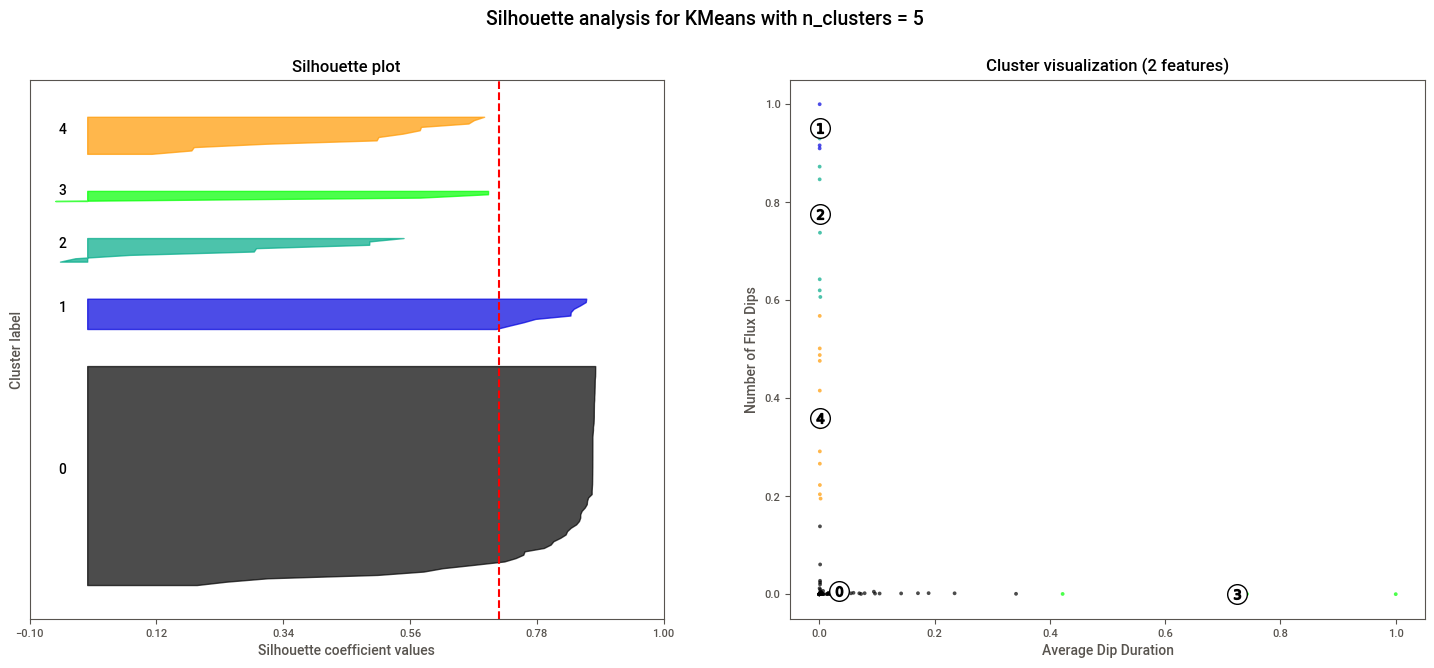

In [ ]:
# Ensure you use only the feature columns
X = x_df[["avg_dip_duration", "num_flux_dips", "flux_std"]].values
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, average silhouette_score = {silhouette_avg:.4f}")

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_vals = sample_silhouette_values[cluster_labels == i]
        ith_vals.sort()
        size = ith_vals.shape[0]
        y_upper = y_lower + size

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The Silhouette plot for the various clusters.")
    ax1.set_xlabel("The Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.linspace(-0.1, 1.0, 6))

    # 2D cluster plot (first two features)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor='k')

    ax2.set_title("The Visualization of the clusteered data (2 features)")
    ax2.set_xlabel("Average Dip Duration")
    ax2.set_ylabel("Number of Flux Dips")

    plt.suptitle(f"Silhouette analysis for KMeans with n_clusters = {n_clusters}", fontsize=14, fontweight='bold')
    plt.show()

5.8 Data Insights from silhouette plots

 - best value is 1 => data point is very compact
 - worst value is -1 = vlaues may have been assigned to the wrong clusters
 - values of zero => overlapping clusters
 - the horizontal coloured irregular bars represents clusters and the width of the score represent a silhuette score
 - red dashed line gives average silhouette score

 
```sh
For n_clusters = 2, the average silhouette_score is: 0.7577
For n_clusters = 3, the average silhouette_score is: 0.7044
For n_clusters = 4, the average silhouette_score is: 0.7463
For n_clusters = 5, the average silhouette_score is: 0.7143
For n_clusters = 6, the average silhouette_score is: 0.7146
For n_clusters = 7, the average silhouette_score is: 0.7201
```
 - k=2 has thre highest score at  .75 => this is our best k value
 - k = 4 and 8 preform reasonably well also with high values
 - k=3 does nto perform well

###  Step 6 - Conclusion and Learnings

- The data initially performed very well. All graphs and analysis as went displayed and looked as I had expected.
- In the clustering phase the data may be performgin fine but the graphs do not look as I expected, althoguh as thsi is my firsttime workign with scientific dat oin this scale perhaps my expectations of what the data should lok like is incorrect. It may very well be performing as expected.... 
- The hope was we would see cluster of data where dips occurred at the same frequency intervals. However that was not really was we observed in our clustering analysis
- Was our dataset big enough to spot a planet transitioning across a star.I do not know the answer to this. Repeating the process with a larger dataset may give better results. Perhaps the period of transition of a planet across a star is longer on this sector.
- Data in the clustering phase didn't Noy quite sure how to interpret the results and plots of the clustering.
    - a lot of zero values or near zero values. This mayh have been how I dealt with the outliers MinMaxScaler and Winsorising
- DBScan was run also on the and the values below were determined but it was hard to put an interpretation on them. There is valid clusters present but again the data looked a bit off. 
    - eps ~ 0.15
    - minPts ~ 4    
- did we use enough data. We could take a larger set fo data and from other sectors. There are challenges with this but the. Aggregating the compute or sharing the analysis is a good approach to spread the burden.
- I had initially thought the complexity  of the dat coudl be overwhelming but the data itself is not overwhelmign once yuo overcome the intial shock of the column names and understanding their meaning, or mostly understanding their meaning.
- There was a lot of learning around hgwo the scientific community process data. Data Analysis is a key part of scientific work. Identifyign efficient ways to standardise and 

### Challenges

- There is no shortage of data. However it is diffficult and time consuming finding the correct data and gaining an understanding of it. Thats a skill in itself
- I need to work with the data for an extended period to gain good insight into it and how to manage it
- Processing time
    - we used a subset of 100 files - each of which contained approx 12K records. The amount of data we did not use was many multiples of this
    - This resulted in long processing times for some tasks
    - 

### Improvements

- get mroe data points to cross check based on light curve per star such as the duration of the dips, how consistenmt the dip is i.e. depth, how long it lasts for (may be able to get diameter of planet based on duration of dip)
- DBScan was run also on the and the values below were determined but it was hard to put an interpretation on them. There is valid clusters present but again the data looked a bit off. 
    - eps ~ 0.15
    - minPts ~ 4   
- More compute power. There is a lot of data to process, even our small subset of data
- Need to do process this type of data regularly to gain domain knowledge, tips and tricks for dealing with it. 
- Perform on a different sector over sa different time and se if it is any different.
- Perform in same sector but differnt rime period and see data performs differently.
- I will be quicker next time...

### Appendix - References

- [1] [methods for detecting dips in curves - LightKurve package] > https://lightkurve.github.io/lightkurve/tutorials/3-science-examples/exoplanets-identifying-transiting-planet-signals.html
- [2][Kepler: A Search for Terrestrial Planets](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/archive_manual.pdf)
- [3][Astropy - Installation](https://docs.astropy.org/en/stable/install.html)
- [4] [INstallation](https://docs.astropy.org/en/stable/install.html)